In [1]:
#Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates

# Scikit-learn modules
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures, label_binarize
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                             roc_auc_score, roc_curve, auc, log_loss, 
                             precision_recall_fscore_support, precision_recall_curve, 
                             fbeta_score, matthews_corrcoef)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA

# XGBoost
import xgboost as xgb

# TensorFlow and Keras modules
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# Statsmodels and other statistical tools
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from scipy.stats import uniform, randint

# Cosine similarity for recommender system
from sklearn.metrics.pairwise import cosine_similarity

# SHAP for interpretability
import shap

In [2]:
# Set seed for reproducibility
np.random.seed(40399224)

# Read in data
data = pd.read_csv("music_genre.csv")

In [3]:
#Pre Cleaning Data Summary

# Summary of data
print(data.describe())
print(data.columns)
print(data.info())

        instance_id    popularity  acousticness  danceability   duration_ms  \
count  50000.000000  50000.000000  50000.000000  50000.000000  5.000000e+04   
mean   55888.396360     44.220420      0.306383      0.558241  2.212526e+05   
std    20725.256253     15.542008      0.341340      0.178632  1.286720e+05   
min    20002.000000      0.000000      0.000000      0.059600 -1.000000e+00   
25%    37973.500000     34.000000      0.020000      0.442000  1.748000e+05   
50%    55913.500000     45.000000      0.144000      0.568000  2.192810e+05   
75%    73863.250000     56.000000      0.552000      0.687000  2.686122e+05   
max    91759.000000     99.000000      0.996000      0.986000  4.830606e+06   

             energy  instrumentalness      liveness      loudness  \
count  50000.000000      50000.000000  50000.000000  50000.000000   
mean       0.599755          0.181601      0.193896     -9.133761   
std        0.264559          0.325409      0.161637      6.162990   
min        0

In [4]:
data.describe(include=['O'])

artist_name track_name    key   mode  tempo obtained_date music_genre
count         50000      50000  50000  50000  50000         50000       50000
unique         6863      41699     12      2  29394             5          10
top     empty_field       Home      G  Major      ?         4-Apr  Electronic
freq           2489         16   5727  32099   4980         44748        5000

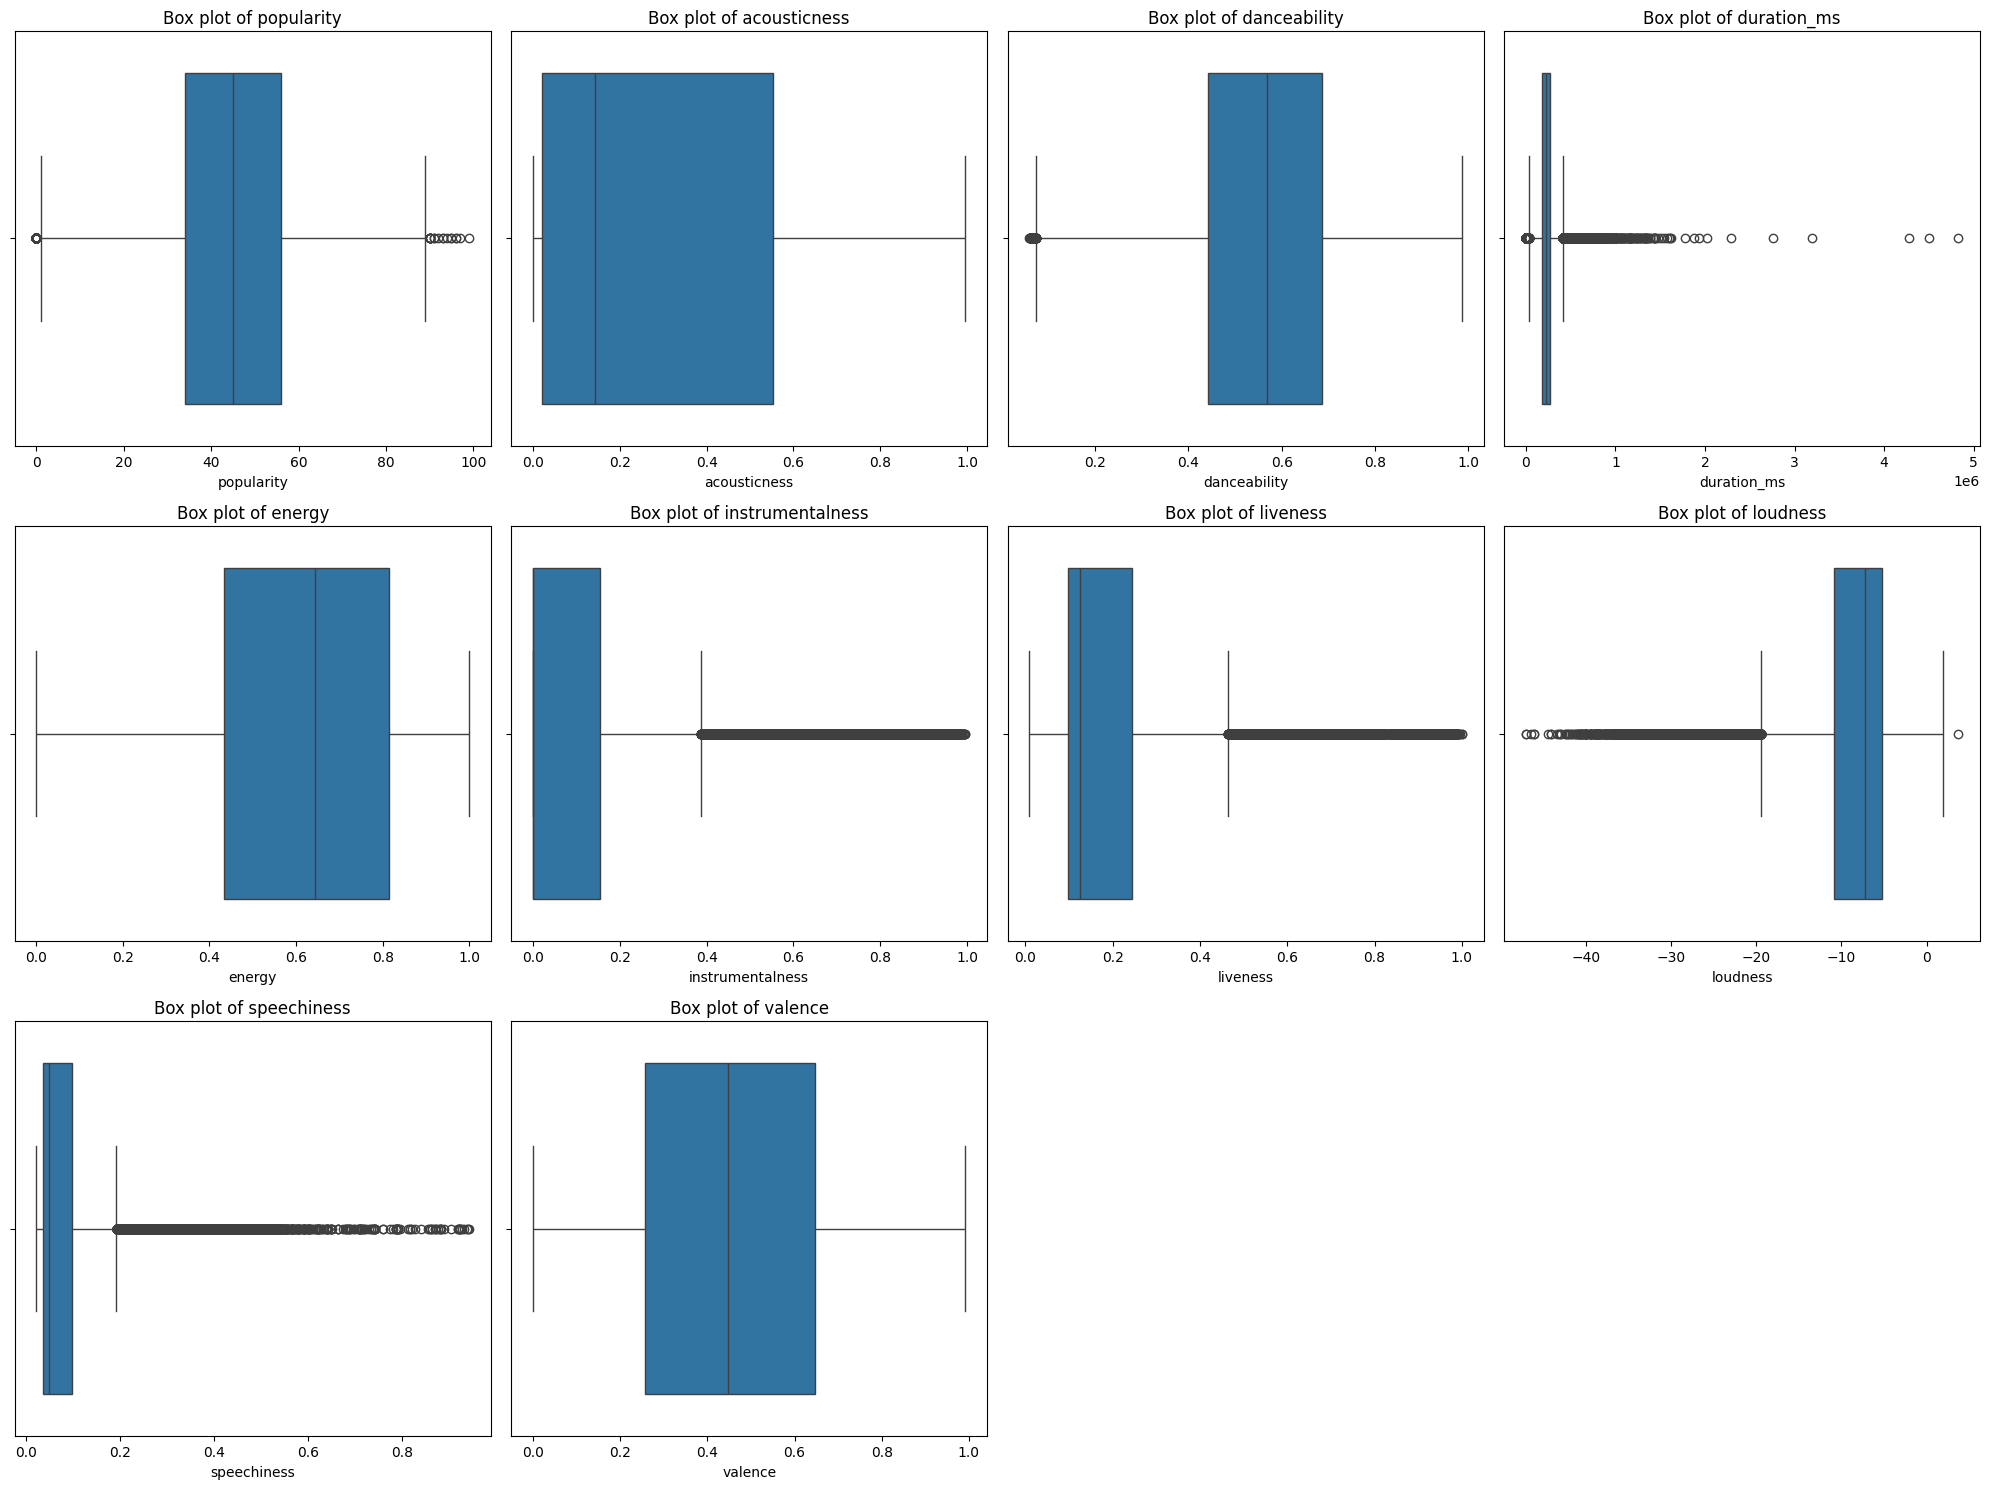

In [5]:
# List of numerical features excluding 'instance_id'
numerical_features = data.select_dtypes(include=[np.number]).columns.tolist()
numerical_features = [feature for feature in numerical_features if feature != 'instance_id']

# Determine the number of rows and columns for the grid
num_features = len(numerical_features)
num_cols = 4  # Number of columns in the grid
num_rows = (num_features // num_cols) + (num_features % num_cols > 0)

# Create a grid of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 5))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each numerical feature in the grid
for i, feature in enumerate(numerical_features):
    sns.boxplot(x=data[feature], ax=axes[i])
    axes[i].set_title(f'Box plot of {feature}')
    axes[i].set_xlabel(feature)

# Remove any empty subplots
for i in range(num_features, len(axes)):
    fig.delaxes(axes[i])

# Adjust the layout
plt.tight_layout()
plt.show()

In [6]:
# Data Quality

# Change character columns to categorical
data = data.apply(lambda x: x.astype('category') if x.dtypes == 'object' else x)

print(data.describe())

# Dealing with categorical data errors

data_levels = {col: data[col].cat.categories.tolist() for col in data.select_dtypes(include='category')}
print(data_levels)

        instance_id    popularity  acousticness  danceability   duration_ms  \
count  50000.000000  50000.000000  50000.000000  50000.000000  5.000000e+04   
mean   55888.396360     44.220420      0.306383      0.558241  2.212526e+05   
std    20725.256253     15.542008      0.341340      0.178632  1.286720e+05   
min    20002.000000      0.000000      0.000000      0.059600 -1.000000e+00   
25%    37973.500000     34.000000      0.020000      0.442000  1.748000e+05   
50%    55913.500000     45.000000      0.144000      0.568000  2.192810e+05   
75%    73863.250000     56.000000      0.552000      0.687000  2.686122e+05   
max    91759.000000     99.000000      0.996000      0.986000  4.830606e+06   

             energy  instrumentalness      liveness      loudness  \
count  50000.000000      50000.000000  50000.000000  50000.000000   
mean       0.599755          0.181601      0.193896     -9.133761   
std        0.264559          0.325409      0.161637      6.162990   
min        0

In [7]:
# Zeroes

# Columns to check
columns_to_check = ['popularity', 'acousticness', 'instrumentalness']

# Count the number of zeros in each specified column
zero_counts = {column: (data[column] == 0).sum() for column in columns_to_check}

# Display the counts
for column, count in zero_counts.items():
    print(f"Number of zeros in '{column}': {count}")

Number of zeros in 'popularity': 694
Number of zeros in 'acousticness': 1
Number of zeros in 'instrumentalness': 15001


In [8]:
# Describe the 'instrumentalness' column for each genre
instrumentalness_description = data.groupby('music_genre')['instrumentalness'].describe()

# Display the description
print(instrumentalness_description)

              count      mean       std  min      25%       50%       75%  \
music_genre                                                                 
Alternative  5000.0  0.060818  0.174351  0.0  0.00000  0.000068  0.006600   
Anime        5000.0  0.278057  0.390610  0.0  0.00000  0.000400  0.768000   
Blues        5000.0  0.094134  0.213205  0.0  0.00001  0.000957  0.038000   
Classical    5000.0  0.600692  0.378027  0.0  0.14875  0.832000  0.905000   
Country      5000.0  0.005320  0.041110  0.0  0.00000  0.000000  0.000039   
Electronic   5000.0  0.348139  0.361742  0.0  0.00316  0.182000  0.749250   
Hip-Hop      5000.0  0.010836  0.073129  0.0  0.00000  0.000000  0.000011   
Jazz         5000.0  0.354271  0.383342  0.0  0.00017  0.120500  0.797000   
Rap          5000.0  0.009084  0.065314  0.0  0.00000  0.000000  0.000010   
Rock         5000.0  0.054656  0.166545  0.0  0.00000  0.000044  0.005115   

               max  
music_genre         
Alternative  0.942  
Anime       

/var/folders/jn/3zj3scvj4nd78bp0j6pqxpdm0000gn/T/ipykernel_79918/682833374.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  instrumentalness_description = data.groupby('music_genre')['instrumentalness'].describe()


In [9]:
# Missing data

print(f"Total missing values: {data.isna().sum().sum()}")

# Show NA as percentage
na_percentage = (data.isna().sum() * 100) / len(data)
print(na_percentage)

# Check for missing values in each column
na_count = data.isna().sum()
print(na_count)

# Display columns with NA values
cols_with_na = na_count[na_count > 0].index.tolist()
print(cols_with_na)

# Show NA as percentage
na_percentage = (data.isna().sum() * 100) / len(data)
print(na_percentage)

# Identify rows with any NA values
rows_with_na = data.isna().any(axis=1)

# Display rows with NA values
data_na = data[rows_with_na]
print("Rows with NA values:")
print(data_na)

Total missing values: 90
instance_id         0.009999
artist_name         0.009999
track_name          0.009999
popularity          0.009999
acousticness        0.009999
danceability        0.009999
duration_ms         0.009999
energy              0.009999
instrumentalness    0.009999
key                 0.009999
liveness            0.009999
loudness            0.009999
mode                0.009999
speechiness         0.009999
tempo               0.009999
obtained_date       0.009999
valence             0.009999
music_genre         0.009999
dtype: float64
instance_id         5
artist_name         5
track_name          5
popularity          5
acousticness        5
danceability        5
duration_ms         5
energy              5
instrumentalness    5
key                 5
liveness            5
loudness            5
mode                5
speechiness         5
tempo               5
obtained_date       5
valence             5
music_genre         5
dtype: int64
['instance_id', 'artist_name'

In [10]:
# Drop rows with NAs
rows_to_drop = [10000, 10001, 10002, 10003, 10004]

# Remove the specified rows
data = data.drop(index=rows_to_drop)

print(f"Total missing values after dropping rows: {data.isna().sum().sum()}")

Total missing values after dropping rows: 0


In [11]:
#Clean Duration and Tempo columns

print(data['duration_ms'].value_counts())

print(data['tempo'].value_counts())

# Replace -1 in duration_ms with NaN to identify missing values
data['duration_ms'] = data['duration_ms'].replace(-1, np.nan)

# Convert the tempo column to numeric, setting invalid parsing ('?') to NaN
data['tempo'] = pd.to_numeric(data['tempo'], errors='coerce')

# Calculate the mean values, ignoring NaNs
mean_duration_ms = data['duration_ms'].mean()
mean_tempo = data['tempo'].mean()

# Replace NaNs with the mean values
data['duration_ms'].fillna(mean_duration_ms, inplace=True)
data['tempo'].fillna(mean_tempo, inplace=True)

duration_ms
-1.0         4939
 240000.0      33
 192000.0      32
 180000.0      28
 216000.0      20
             ... 
 154574.0       1
 359213.0       1
 656213.0       1
 506320.0       1
 189483.0       1
Name: count, Length: 26028, dtype: int64
tempo
?                     4980
120.0                   17
140.007                 17
100.00299999999999      16
100.00200000000001      15
                      ... 
140.447                  1
140.444                  1
140.433                  1
140.43200000000002       1
152.60399999999998       1
Name: count, Length: 29394, dtype: int64


/var/folders/jn/3zj3scvj4nd78bp0j6pqxpdm0000gn/T/ipykernel_79918/3240384150.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['duration_ms'].fillna(mean_duration_ms, inplace=True)
/var/folders/jn/3zj3scvj4nd78bp0j6pqxpdm0000gn/T/ipykernel_79918/3240384150.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting

In [12]:
# Verify the changes
print(data['duration_ms'].value_counts())
print(data['tempo'].value_counts())

duration_ms
245503.541466    4939
240000.000000      33
192000.000000      32
180000.000000      28
216000.000000      20
                 ... 
154574.000000       1
359213.000000       1
656213.000000       1
506320.000000       1
189483.000000       1
Name: count, Length: 26028, dtype: int64
tempo
119.952961    4980
140.007000      17
120.000000      17
100.003000      16
100.014000      15
              ... 
137.046000       1
136.378000       1
93.041000        1
113.982000       1
99.201000        1
Name: count, Length: 29394, dtype: int64


In [13]:
#Post Cleaning Data Summary
data.describe()

instance_id    popularity  acousticness  danceability   duration_ms  \
count  50000.000000  50000.000000  50000.000000  50000.000000  5.000000e+04   
mean   55888.396360     44.220420      0.306383      0.558241  2.455035e+05   
std    20725.256253     15.542008      0.341340      0.178632  1.057864e+05   
min    20002.000000      0.000000      0.000000      0.059600  1.550900e+04   
25%    37973.500000     34.000000      0.020000      0.442000  1.948750e+05   
50%    55913.500000     45.000000      0.144000      0.568000  2.360270e+05   
75%    73863.250000     56.000000      0.552000      0.687000  2.686122e+05   
max    91759.000000     99.000000      0.996000      0.986000  4.830606e+06   

             energy  instrumentalness      liveness      loudness  \
count  50000.000000      50000.000000  50000.000000  50000.000000   
mean       0.599755          0.181601      0.193896     -9.133761   
std        0.264559          0.325409      0.161637      6.162990   
min        0.000792          0.000000      0.009670    -47.046000   
25%        0.433000          0.000000      0.096900    -10.860000   
50%        0.643000          0.000158      0.126000     -7.276500   
75%        0.815000          0.155000      0.244000     -5.173000   
max        0.999000          0.996000      1.000000      3.744000   

        speechiness         tempo       valence  
count  50000.000000  50000.000000  50000.000000  
mean       0.093586    119.952961      0.456264  
std        0.101373     29.075697      0.247119  
min        0.022300     34.347000      0.000000  
25%        0.036100     96.775750      0.257000  
50%        0.048900    119.952961      0.448000  
75%        0.098525    139.468250      0.648000  
max        0.942000    220.276000      0.992000

In [14]:
# List of numerical features, excluding 'instance_id', 'key', 'mode', and 'music_genre'
numerical_features = data.select_dtypes(include=[np.number]).columns.tolist()
numerical_features = [feature for feature in numerical_features if feature not in ['instance_id', 'key', 'mode']]

# Group by 'music_genre' and calculate the mean for each numeric feature
for feature in numerical_features:
    grouped_data = data[['music_genre', feature]].groupby('music_genre', as_index=False).mean()
    sorted_grouped_data = grouped_data.sort_values(by=feature, ascending=False)
    print(f"\nMean values of {feature} grouped by 'music_genre':")
    print(sorted_grouped_data)

/var/folders/jn/3zj3scvj4nd78bp0j6pqxpdm0000gn/T/ipykernel_79918/4165292960.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data[['music_genre', feature]].groupby('music_genre', as_index=False).mean()



Mean values of popularity grouped by 'music_genre':
   music_genre  popularity
8          Rap     60.4974
9         Rock     59.6412
6      Hip-Hop     58.3996
0  Alternative     50.2242
4      Country     46.0100
7         Jazz     40.9286
5   Electronic     38.1118
2        Blues     34.8040
3    Classical     29.3158
1        Anime     24.2716


/var/folders/jn/3zj3scvj4nd78bp0j6pqxpdm0000gn/T/ipykernel_79918/4165292960.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data[['music_genre', feature]].groupby('music_genre', as_index=False).mean()



Mean values of acousticness grouped by 'music_genre':
   music_genre  acousticness
3    Classical      0.869139
7         Jazz      0.494564
2        Blues      0.317830
1        Anime      0.286968
4      Country      0.268827
9         Rock      0.191394
6      Hip-Hop      0.179093
8          Rap      0.169057
0  Alternative      0.164983
5   Electronic      0.121971

Mean values of danceability grouped by 'music_genre':
   music_genre  danceability
6      Hip-Hop      0.717373
8          Rap      0.696605
5   Electronic      0.619220
7         Jazz      0.584736
4      Country      0.577316
0  Alternative      0.541124
9         Rock      0.539230
2        Blues      0.529243
1        Anime      0.471002
3    Classical      0.306560

Mean values of duration_ms grouped by 'music_genre':
   music_genre    duration_ms
3    Classical  303104.910538
5   Electronic  268269.121906
7         Jazz  262495.598222
2        Blues  253016.834906
9         Rock  237712.473305
0  Alternative  23

/var/folders/jn/3zj3scvj4nd78bp0j6pqxpdm0000gn/T/ipykernel_79918/4165292960.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data[['music_genre', feature]].groupby('music_genre', as_index=False).mean()
/var/folders/jn/3zj3scvj4nd78bp0j6pqxpdm0000gn/T/ipykernel_79918/4165292960.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data[['music_genre', feature]].groupby('music_genre', as_index=False).mean()
/var/folders/jn/3zj3scvj4nd78bp0j6pqxpdm0000gn/T/ipykernel_79918/4165292960.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a fu

In [15]:
# List of numerical features excluding 'instance_id', 'key', 'mode', and 'music_genre'
numerical_features = data.select_dtypes(include=[np.number]).columns.tolist()
numerical_features = [feature for feature in numerical_features if feature not in ['instance_id', 'key', 'mode', 'music_genre']]

# Group by 'key' and calculate the mean for each numerical feature
grouped_by_key = data.groupby('key')[numerical_features].mean().reset_index()

# Group by 'mode' and calculate the mean for each numerical feature
grouped_by_mode = data.groupby('mode')[numerical_features].mean().reset_index()

# Group by 'music_genre' and calculate the mean for each numerical feature
grouped_by_genre = data.groupby('music_genre')[numerical_features].mean().reset_index()

# Display the grouped data
print("Mean values of numerical features grouped by 'key':")
print(grouped_by_key)

print("\nMean values of numerical features grouped by 'mode':")
print(grouped_by_mode)

print("\nMean values of numerical features grouped by 'music_genre':")
print(grouped_by_genre)

Mean values of numerical features grouped by 'key':
   key  popularity  acousticness  danceability    duration_ms    energy  \
0    A   43.509223      0.314786      0.548966  245785.251111  0.594827   
1   A#   44.412992      0.334649      0.576041  247531.271137  0.579696   
2    B   45.662180      0.241823      0.581897  242138.460205  0.646089   
3    C   43.301702      0.340065      0.545203  247826.855851  0.572775   
4   C#   46.806660      0.235449      0.600170  238668.247376  0.635782   
5    D   43.599430      0.309949      0.541076  248802.729389  0.603060   
6   D#   41.955975      0.442210      0.509633  249863.964657  0.516707   
7    E   43.592819      0.314309      0.533237  249800.336848  0.598967   
8    F   43.082009      0.353433      0.551330  249895.207929  0.571135   
9   F#   45.534021      0.254026      0.573403  240846.837733  0.636695   
10   G   42.926838      0.317050      0.545565  246309.119021  0.593716   
11  G#   46.005122      0.288031      0.575717  

/var/folders/jn/3zj3scvj4nd78bp0j6pqxpdm0000gn/T/ipykernel_79918/2136307151.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_by_key = data.groupby('key')[numerical_features].mean().reset_index()
/var/folders/jn/3zj3scvj4nd78bp0j6pqxpdm0000gn/T/ipykernel_79918/2136307151.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_by_mode = data.groupby('mode')[numerical_features].mean().reset_index()
/var/folders/jn/3zj3scvj4nd78bp0j6pqxpdm0000gn/T/ipykernel_79918/2136307151.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. P

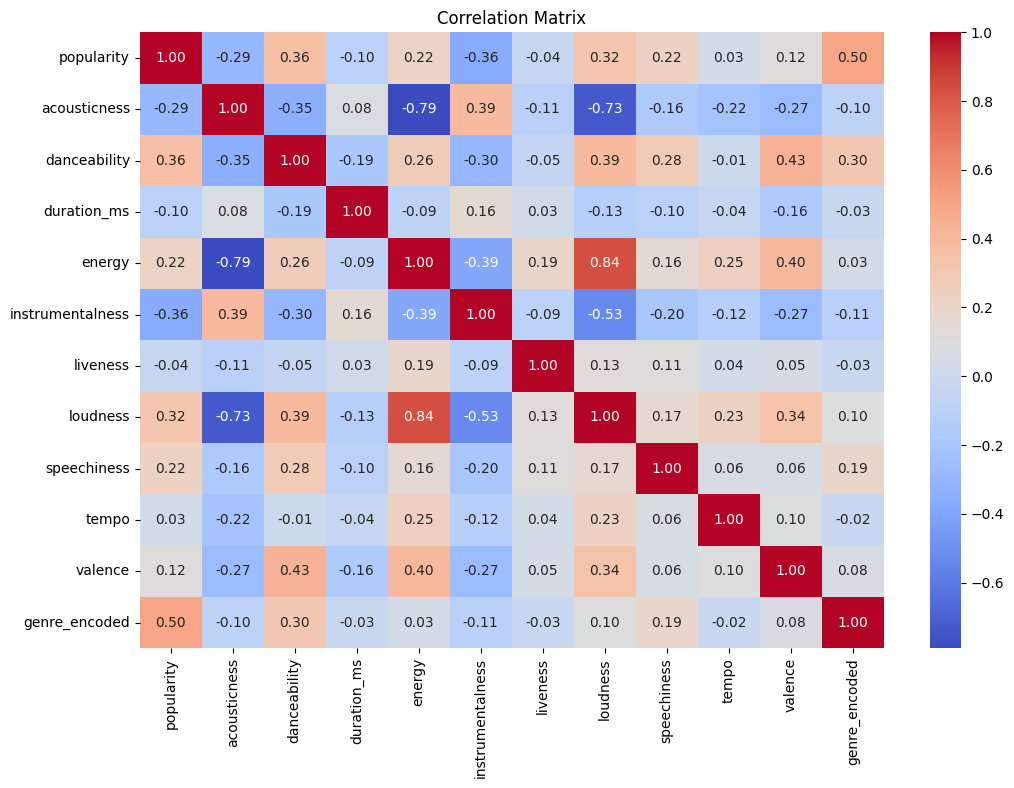

In [16]:
#Correlation

# Encode the 'music_genre' variable
label_encoder = LabelEncoder()
data['genre_encoded'] = label_encoder.fit_transform(data['music_genre'])

# Select numerical features, excluding 'instance_id'
numerical_features = data.select_dtypes(include=[np.number]).columns.tolist()
numerical_features = [feature for feature in numerical_features if feature not in ['instance_id']]

# Ensure 'genre_encoded' is included
if 'genre_encoded' not in numerical_features:
    numerical_features.append('genre_encoded')

# Compute the correlation matrix
corr_matrix = data[numerical_features].corr()

# Visualize the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

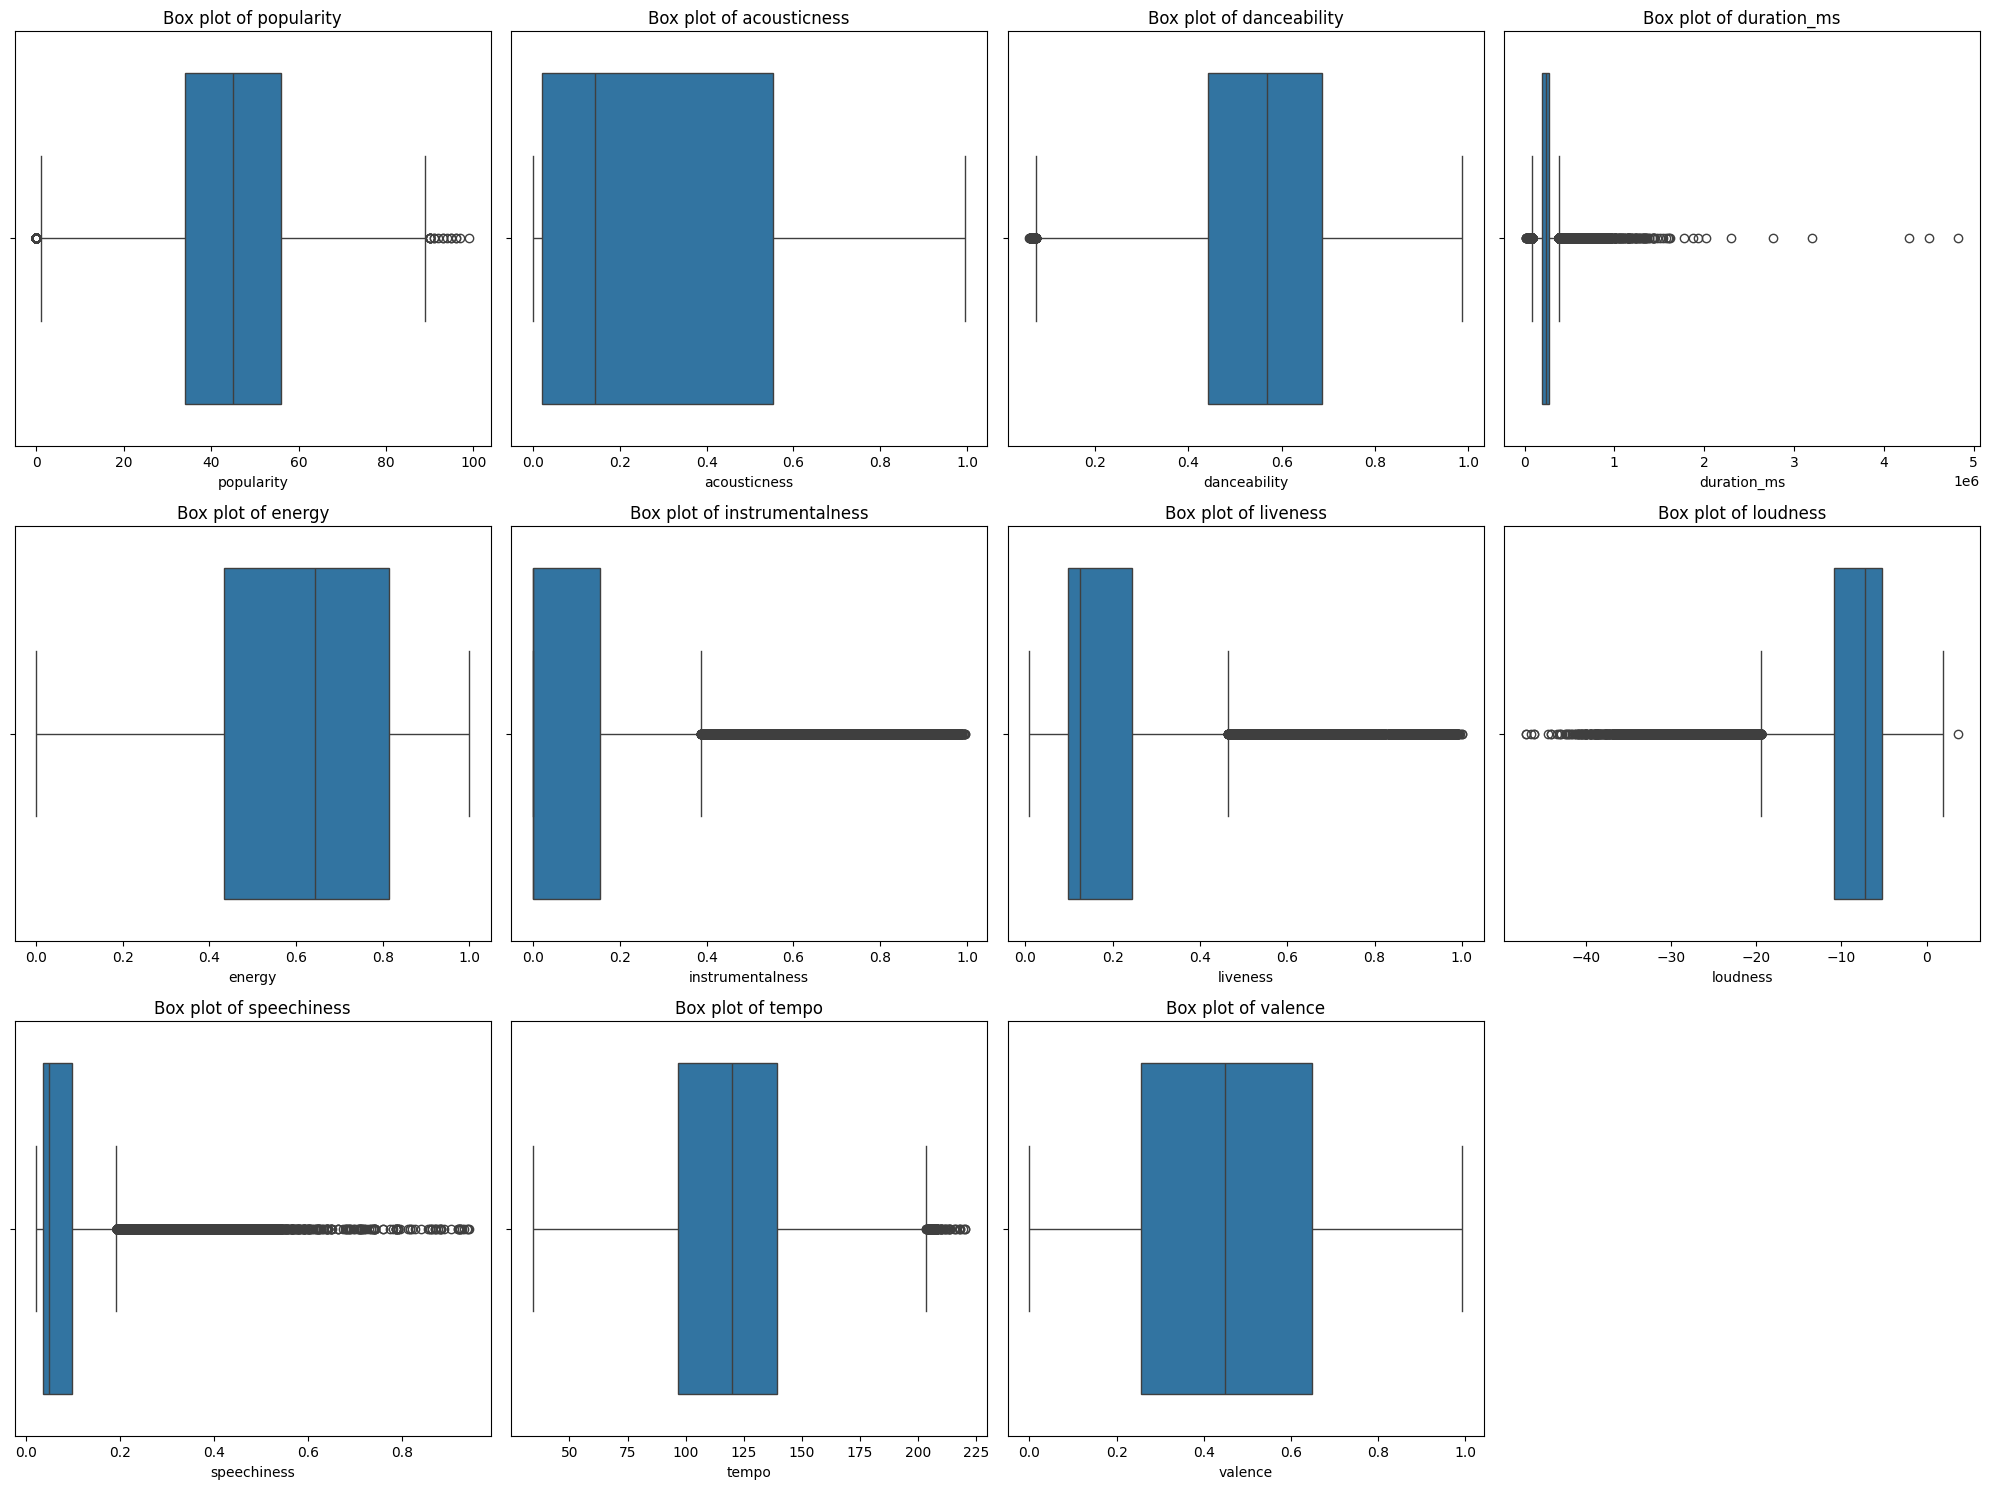

In [17]:
# Encode the 'music_genre' variable
label_encoder = LabelEncoder()
data['genre_encoded'] = label_encoder.fit_transform(data['music_genre'])

# List of numerical features excluding 'instance_id' and 'genre_encoded'
numerical_features = data.select_dtypes(include=[np.number]).columns.tolist()
numerical_features = [feature for feature in numerical_features if feature not in ['instance_id', 'genre_encoded']]

# Determine the number of rows and columns for the grid
num_features = len(numerical_features)
num_cols = 4  # Number of columns in the grid
num_rows = (num_features // num_cols) + (num_features % num_cols > 0)

# Create a grid of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 5))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each numerical feature in the grid
for i, feature in enumerate(numerical_features):
    sns.boxplot(x=data[feature], ax=axes[i])
    axes[i].set_title(f'Box plot of {feature}')
    axes[i].set_xlabel(feature)

# Remove any empty subplots
for i in range(num_features, len(axes)):
    fig.delaxes(axes[i])

# Adjust the layout
plt.tight_layout()
plt.show()

In [18]:
#Export data for visualization
data.to_csv("music_genre_cleaned.csv", index=False)

In [20]:
# Load the data
data = pd.read_csv("music_genre_cleaned.csv")

In [21]:
# Encode the target variable 'music_genre'
label_encoder = LabelEncoder()
data['genre_encoded'] = label_encoder.fit_transform(data['music_genre'])

# Drop unnecessary columns
data = data.drop(columns=['instance_id', 'obtained_date', 'track_name', 'artist_name', 'music_genre'])

# One-hot encode categorical features ('key' and 'mode')
data = pd.get_dummies(data, columns=['key', 'mode'], drop_first=True)

# Select features and target
features = data.drop(columns=['genre_encoded'])
target = data['genre_encoded']

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.3, random_state=40399224)

In [22]:
#Run Base Models

# Function to evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    return accuracy

# Logistic Regression
print("Logistic Regression")
logistic_model = LogisticRegression(max_iter=1000)
accuracy_logistic = evaluate_model(logistic_model, X_train, X_test, y_train, y_test)

# Decision Tree
print("\nDecision Tree")
decision_tree_model = DecisionTreeClassifier()
accuracy_tree = evaluate_model(decision_tree_model, X_train, X_test, y_train, y_test)

# Random Forest
print("\nRandom Forest")
random_forest_model = RandomForestClassifier()
accuracy_forest = evaluate_model(random_forest_model, X_train, X_test, y_train, y_test)

# Support Vector Machine (SVM)
print("\nSupport Vector Machine")
svm_model = SVC()
accuracy_svm = evaluate_model(svm_model, X_train, X_test, y_train, y_test)

# k-Nearest Neighbors (k-NN)
print("\nk-Nearest Neighbors")
knn_model = KNeighborsClassifier()
accuracy_knn = evaluate_model(knn_model, X_train, X_test, y_train, y_test)

# XGBoost
print("\nXGBoost")
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
accuracy_xgb = evaluate_model(xgb_model, X_train, X_test, y_train, y_test)

# Convolutional Neural Network (CNN)
print("\nConvolutional Neural Network")
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

cnn_model = Sequential()
cnn_model.add(Conv1D(64, 2, activation='relu', input_shape=(X_train_cnn.shape[1], 1)))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(100, activation='relu'))
cnn_model.add(Dense(len(np.unique(y_train)), activation='softmax'))

cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_model.fit(X_train_cnn, y_train, epochs=10, batch_size=32, verbose=2)
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test_cnn, y_test, verbose=0)

print(f"CNN Accuracy: {cnn_accuracy}")

# Summary of Accuracies
print("\nSummary of Accuracies")
print(f"Logistic Regression Accuracy: {accuracy_logistic}")
print(f"Decision Tree Accuracy: {accuracy_tree}")
print(f"Random Forest Accuracy: {accuracy_forest}")
print(f"SVM Accuracy: {accuracy_svm}")
print(f"k-NN Accuracy: {accuracy_knn}")
print(f"XGBoost Accuracy: {accuracy_xgb}")
print(f"CNN Accuracy: {cnn_accuracy}")

Logistic Regression
Accuracy: 0.5291333333333333
Classification Report:
               precision    recall  f1-score   support

           0       0.37      0.31      0.33      1486
           1       0.65      0.62      0.64      1532
           2       0.48      0.47      0.47      1463
           3       0.80      0.80      0.80      1522
           4       0.45      0.57      0.50      1487
           5       0.56      0.58      0.57      1418
           6       0.47      0.49      0.48      1525
           7       0.50      0.41      0.45      1470
           8       0.46      0.39      0.43      1534
           9       0.53      0.64      0.58      1563

    accuracy                           0.53     15000
   macro avg       0.53      0.53      0.53     15000
weighted avg       0.53      0.53      0.53     15000

Confusion Matrix:
 [[ 454    6   44    4  355   90  127   93   54  259]
 [  43  955  173  166   60   95    0   34    1    5]
 [  55  221  684   22  162   77    2  175  

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:58:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.5732666666666667
Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.40      0.42      1486
           1       0.83      0.78      0.80      1532
           2       0.61      0.55      0.58      1463
           3       0.86      0.85      0.86      1522
           4       0.60      0.62      0.61      1487
           5       0.65      0.62      0.63      1418
           6       0.37      0.39      0.38      1525
           7       0.54      0.54      0.54      1470
           8       0.35      0.35      0.35      1534
           9       0.51      0.63      0.56      1563

    accuracy                           0.57     15000
   macro avg       0.58      0.57      0.57     15000
weighted avg       0.58      0.57      0.57     15000

Confusion Matrix:
 [[ 592   14   31    5  188   61  128   77   79  311]
 [  34 1195  101   71   46   55    1   21    1    7]
 [  65   92  804   21  106   78    3  200    3   91]
 [  29   5

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1094/1094 - 8s - 7ms/step - accuracy: 0.4725 - loss: 1.4177
Epoch 2/10
1094/1094 - 2s - 2ms/step - accuracy: 0.5305 - loss: 1.2476
Epoch 3/10
1094/1094 - 10s - 9ms/step - accuracy: 0.5410 - loss: 1.2063
Epoch 4/10
1094/1094 - 3s - 3ms/step - accuracy: 0.5502 - loss: 1.1778
Epoch 5/10
1094/1094 - 9s - 9ms/step - accuracy: 0.5570 - loss: 1.1581
Epoch 6/10
1094/1094 - 4s - 4ms/step - accuracy: 0.5636 - loss: 1.1372
Epoch 7/10
1094/1094 - 10s - 9ms/step - accuracy: 0.5672 - loss: 1.1254
Epoch 8/10
1094/1094 - 4s - 3ms/step - accuracy: 0.5720 - loss: 1.1137
Epoch 9/10
1094/1094 - 12s - 11ms/step - accuracy: 0.5749 - loss: 1.1038
Epoch 10/10
1094/1094 - 3s - 3ms/step - accuracy: 0.5753 - loss: 1.0978
CNN Accuracy: 0.5694000124931335

Summary of Accuracies
Logistic Regression Accuracy: 0.5291333333333333
Decision Tree Accuracy: 0.4424
Random Forest Accuracy: 0.5482
SVM Accuracy: 0.5593333333333333
k-NN Accuracy: 0.44126666666666664
XGBoost Accuracy: 0.5732666666666667
CNN Accuracy:


XGBoost Assumption Checks


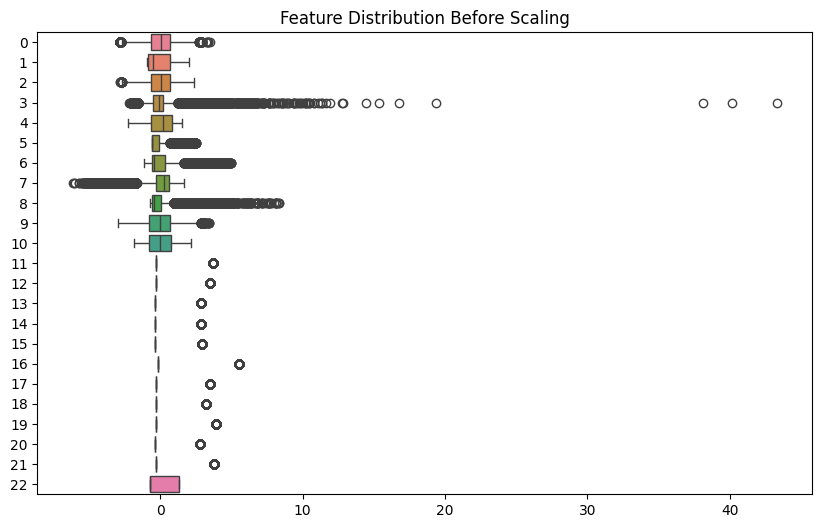

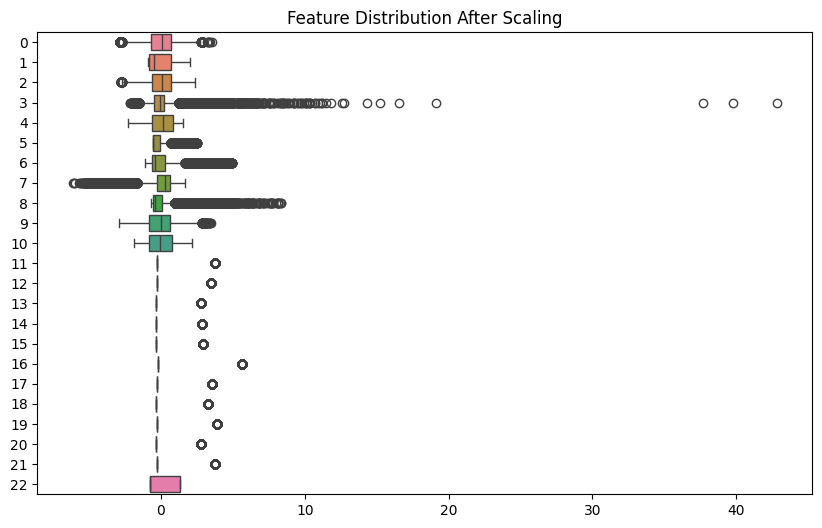

In [23]:
#Base Assumption Checks

# Check feature scaling (Ensure all features are on similar scales)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# XGBoost Assumption Checks
print("\nXGBoost Assumption Checks")

# Check feature scaling (although XGBoost is less sensitive)
plt.figure(figsize=(10, 6))
sns.boxplot(data=X_train, orient='h')
plt.title('Feature Distribution Before Scaling')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=X_train_scaled, orient='h')
plt.title('Feature Distribution After Scaling')
plt.show()



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:03:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


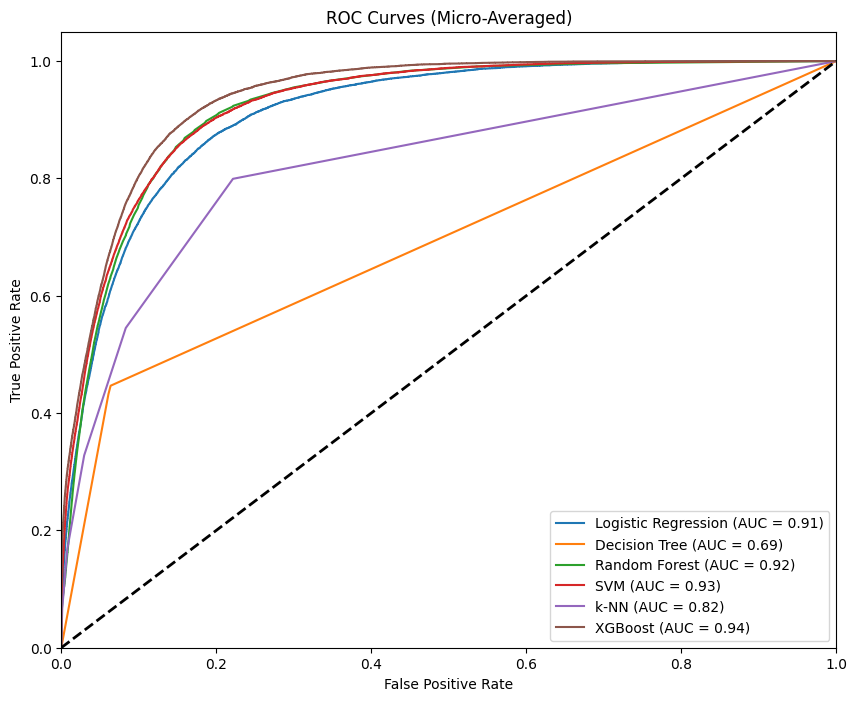

In [24]:

# ROC Curves

# Binarize the output for ROC curve
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_binarized.shape[1]

# Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(probability=True),
    "k-NN": KNeighborsClassifier(),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

# Function to plot ROC Curves
def plot_roc_curves(models, X_test, y_test_binarized):
    plt.figure(figsize=(10, 8))

    for name, model in models.items():
        model.fit(X_train, y_train)  # Ensure models are trained before plotting
        
        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(X_test)
        else:
            y_prob = model.decision_function(X_test)
            y_prob = (y_prob - y_prob.min()) / (y_prob.max() - y_prob.min())  # Scale to [0, 1]

        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_prob[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        
        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_prob.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
        
        plt.plot(fpr["micro"], tpr["micro"], label=f'{name} (AUC = {roc_auc["micro"]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves (Micro-Averaged)')
    plt.legend(loc='lower right')
    plt.show()

# Plot ROC Curves
plot_roc_curves(models, X_test, y_test_binarized)

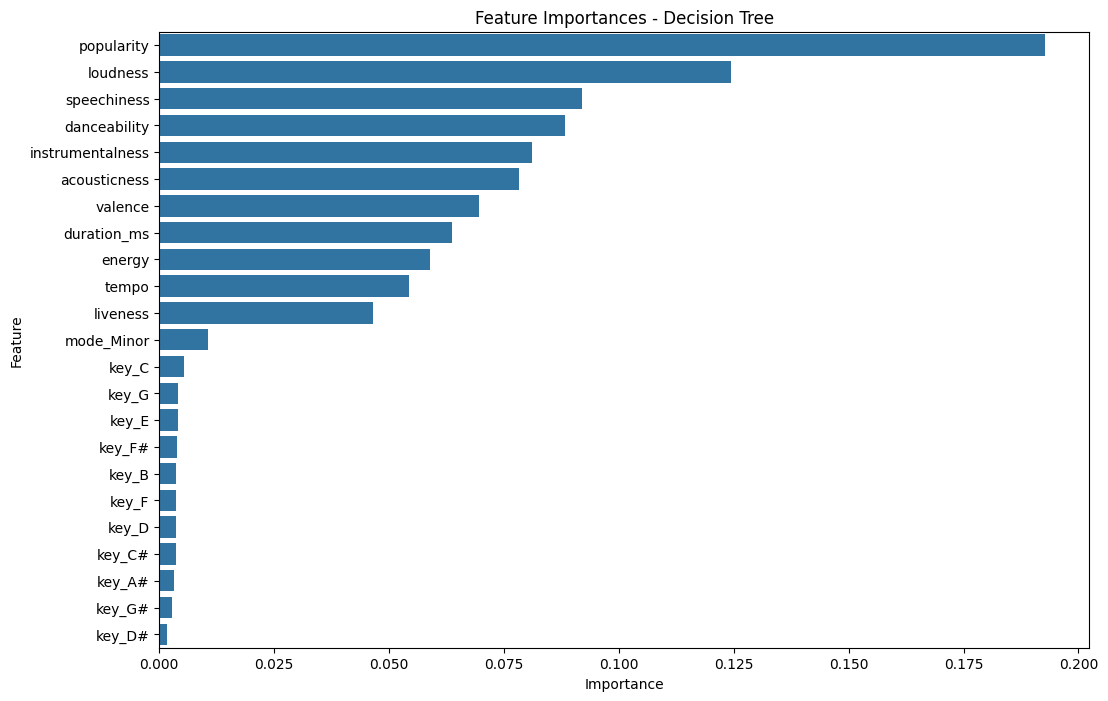

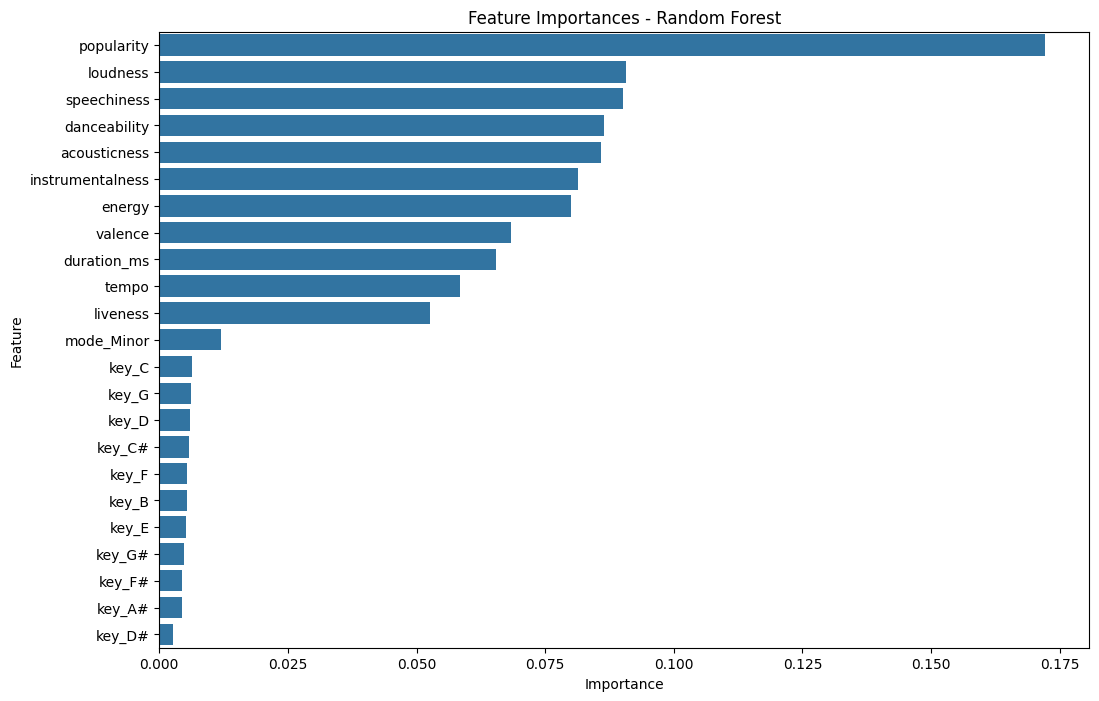

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:05:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


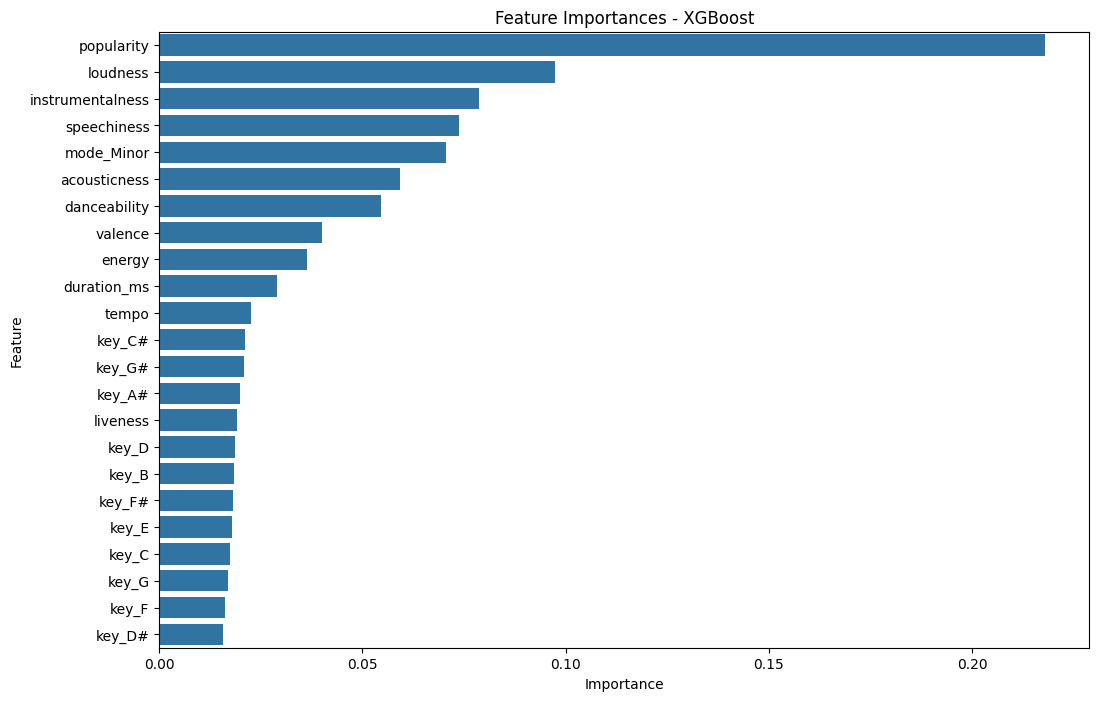

In [25]:
# Function to plot Feature Importances

original_feature_names = features.columns

# Function to plot Feature Importances
def plot_feature_importances(model, X_train, feature_names, model_name):
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
    else:
        result = permutation_importance(model, X_train, y_train, n_repeats=10, random_state=40399224)
        importances = result.importances_mean
    
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
    plt.title(f'Feature Importances - {model_name}')
    plt.show()

# Train models and plot Feature Importances
for name, model in models.items():
    model.fit(X_train, y_train)
    if name in ["Random Forest", "XGBoost", "Decision Tree"]:
        plot_feature_importances(model, X_train, original_feature_names, name)

In [26]:
#Evaluate and Compare Models


def evaluate_model_extended(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    
    if hasattr(model, 'predict_proba'):
        y_prob = model.predict_proba(X_test)
        y_pred = np.argmax(y_prob, axis=1)
    else:
        y_prob = model.predict(X_test)
        y_pred = np.argmax(y_prob, axis=1) if len(y_prob.shape) > 1 else y_prob
    
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    if len(np.unique(y_test)) == 2:  # Binary classification
        roc_auc = roc_auc_score(y_test, y_prob[:, 1])
        fpr, tpr, _ = roc_curve(y_test, y_prob[:, 1])
    else:  # Multiclass classification
        roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
        fpr, tpr, _ = None, None, None
    
    logloss = log_loss(y_test, y_prob)
    
    print(f"\n{model_name} Performance Metrics:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print("Confusion Matrix:\n", conf_matrix)
    if fpr is not None and tpr is not None:
        plt.figure(figsize=(10, 6))
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {model_name}')
        plt.show()
    print(f"ROC AUC: {roc_auc}")
    print(f"Log Loss: {logloss}")

    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'ROC AUC': roc_auc,
        'Log Loss': logloss,
        'Classification Report': classification_report(y_test, y_pred, output_dict=True)
    }

# Define the models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(oob_score=True),
    "Support Vector Machine": SVC(probability=True),
    "k-Nearest Neighbors": KNeighborsClassifier(),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    "CNN": None  # CNN will be handled separately
}


metrics = evaluate_model_extended(logistic_model, X_train, X_test, y_train, y_test, "Logistic Regression")
models_score_table = [metrics]

# Evaluate the remaining models
for model_name, model in models.items():
    if model_name != "Logistic Regression" and model_name != "CNN":
        metrics = evaluate_model_extended(model, X_train, X_test, y_train, y_test, model_name)
        models_score_table.append(metrics)

# Evaluate CNN separately
print("\nConvolutional Neural Network")
cnn_model = Sequential([
    Conv1D(64, 2, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(100, activation='relu'),
    Dense(len(np.unique(y_train)), activation='softmax')
])
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_model.fit(X_train_cnn, y_train, epochs=10, batch_size=32, verbose=2)
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test_cnn, y_test, verbose=0)
y_pred_cnn = cnn_model.predict(X_test_cnn)
cnn_metrics = {
    'Model': 'CNN',
    'Accuracy': cnn_accuracy,
    'ROC AUC': roc_auc_score(y_test, y_pred_cnn, multi_class='ovr'),
    'Log Loss': log_loss(y_test, y_pred_cnn),
    'Classification Report': classification_report(y_test, np.argmax(y_pred_cnn, axis=1), output_dict=True)
}
models_score_table.append(cnn_metrics)

# Convert to DataFrame
models_score_df = pd.DataFrame(models_score_table)
print("\nModel Performance Summary:")
print(models_score_df)

# Identify the best model based on ROC AUC
best_model_idx = models_score_df['ROC AUC'].idxmax()
best_model = models_score_df.iloc[best_model_idx]

print("\nBest Model Based on ROC AUC:")
print(best_model)


Logistic Regression Performance Metrics:
Accuracy: 0.5291333333333333
Precision: 0.5276520233420495
Recall: 0.5291333333333333
F1 Score: 0.5260964342286939
Confusion Matrix:
 [[ 454    6   44    4  355   90  127   93   54  259]
 [  43  955  173  166   60   95    0   34    1    5]
 [  55  221  684   22  162   77    2  175    3   62]
 [  24   92   52 1223   11   42    0   71    0    7]
 [ 108   25  171    3  855   45   18   46   10  206]
 [ 109   95   88   16   69  817   42  117   27   38]
 [  99    0    1    0   55   16  746   24  495   89]
 [  41   68  209   89  122  244   44  606    3   44]
 [ 114    0    0    0   46   10  587   13  602  162]
 [ 187    3   12    3  173   12   32   43  103  995]]
ROC AUC: 0.9051226047523138
Log Loss: 1.2541145364638564

Decision Tree Performance Metrics:
Accuracy: 0.442
Precision: 0.44201980124373963
Recall: 0.442
F1 Score: 0.4418343656738864
Confusion Matrix:
 [[ 425   44   98   29  191  107  119  103  121  249]
 [  39 1033  157  119   45   88    1  

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:08:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Performance Metrics:
Accuracy: 0.5732666666666667
Precision: 0.5776717850206751
Recall: 0.5732666666666667
F1 Score: 0.5742901063374816
Confusion Matrix:
 [[ 592   14   31    5  188   61  128   77   79  311]
 [  34 1195  101   71   46   55    1   21    1    7]
 [  65   92  804   21  106   78    3  200    3   91]
 [  29   54   40 1291    4   30    0   67    0    7]
 [ 109   10   81    1  918   19   17   75   26  231]
 [ 117   51   84   14   25  874   32  155   19   47]
 [  64    1    0    0   17   16  601   14  755   57]
 [  71   19  158   91   63  187   25  791   12   53]
 [  52    0    2    0   16    9  746   13  544  152]
 [ 186    4   18    2  138   11   61   45  109  989]]
ROC AUC: 0.9298905315782182
Log Loss: 1.0634364106808598

Convolutional Neural Network


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1094/1094 - 5s - 5ms/step - accuracy: 0.4726 - loss: 1.4192
Epoch 2/10
1094/1094 - 5s - 4ms/step - accuracy: 0.5290 - loss: 1.2444
Epoch 3/10
1094/1094 - 5s - 5ms/step - accuracy: 0.5414 - loss: 1.2001
Epoch 4/10
1094/1094 - 5s - 5ms/step - accuracy: 0.5497 - loss: 1.1752
Epoch 5/10
1094/1094 - 5s - 5ms/step - accuracy: 0.5567 - loss: 1.1538
Epoch 6/10
1094/1094 - 6s - 5ms/step - accuracy: 0.5637 - loss: 1.1368
Epoch 7/10
1094/1094 - 5s - 5ms/step - accuracy: 0.5673 - loss: 1.1230
Epoch 8/10
1094/1094 - 6s - 5ms/step - accuracy: 0.5730 - loss: 1.1109
Epoch 9/10
1094/1094 - 6s - 5ms/step - accuracy: 0.5765 - loss: 1.0994
Epoch 10/10
1094/1094 - 6s - 6ms/step - accuracy: 0.5778 - loss: 1.0928
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Model Performance Summary:
                    Model  Accuracy   ROC AUC   Log Loss  \
0     Logistic Regression  0.529133  0.905123   1.254115   
1           Decision Tree  0.442000  0.693314  19.810701   
2           Random Forest  0.549600  0.9

In [27]:
#Post Tuning

# Logistic Regression with Polynomial Features
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
features_poly = poly.fit_transform(features_scaled)

# Split the data into training and testing sets for the polynomial features
X_train_poly, X_test_poly, y_train, y_test = train_test_split(features_poly, target, test_size=0.3, random_state=40399224)

# Initialize and fit the logistic regression model
logistic_model = LogisticRegression(solver='lbfgs', max_iter=1000, multi_class='multinomial')
logistic_model.fit(X_train_poly, y_train)

# Evaluate the logistic regression model
accuracy_logistic = evaluate_model(logistic_model, X_train_poly, X_test_poly, y_train, y_test)
print(f"Logistic Regression Accuracy: {accuracy_logistic}")

# Decision Tree with Hyperparameter Tuning
param_grid_dt = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

grid_search_dt = GridSearchCV(estimator=DecisionTreeClassifier(random_state=40399224), param_grid=param_grid_dt, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_dt.fit(X_train, y_train)

best_decision_tree = grid_search_dt.best_estimator_

accuracy_tree = evaluate_model(best_decision_tree, X_train, X_test, y_train, y_test)
print(f"Best parameters for Decision Tree: {grid_search_dt.best_params_}")
print(f"Decision Tree Accuracy: {accuracy_tree}")

# Random Forest with Bagging Different Feature Subsets
base_rf_model = RandomForestClassifier(random_state=40399224)

bagging_rf_model = BaggingClassifier(
    estimator=base_rf_model,
    n_estimators=10,
    max_features=0.5,
    max_samples=0.8,
    bootstrap=True,
    random_state=40399224,
    n_jobs=-1
)

bagging_rf_model.fit(X_train, y_train)

y_pred_rf_bagging = bagging_rf_model.predict(X_test)
accuracy_rf_bagging = accuracy_score(y_test, y_pred_rf_bagging)
print(f"Bagging Random Forest Accuracy: {accuracy_rf_bagging}")

# SVM with Randomized Search
param_dist_svm = {
    'C': uniform(0.1, 3),
    'gamma': uniform(0.01, 0.03),
    'kernel': ['rbf']
}

random_search_svm = RandomizedSearchCV(
    SVC(probability=True, random_state=40399224), 
    param_distributions=param_dist_svm, 
    n_iter=10,
    cv=2,
    scoring='accuracy', 
    n_jobs=-1, 
    random_state=40399224
)

random_search_svm.fit(X_train, y_train)

best_svm = random_search_svm.best_estimator_

accuracy_svm = evaluate_model(best_svm, X_train, X_test, y_train, y_test)
print(f"Best parameters for SVM: {random_search_svm.best_params_}")
print(f"SVM Accuracy: {accuracy_svm}")

# k-NN using Grid Search
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9, 11, 13],
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2]
}

grid_search_knn = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_knn.fit(X_train, y_train)

print(f"Best parameters for k-NN: {grid_search_knn.best_params_}")

y_pred_knn_optimized = grid_search_knn.predict(X_test)
accuracy_knn_optimized = accuracy_score(y_test, y_pred_knn_optimized)
print(f"Optimized k-NN Accuracy: {accuracy_knn_optimized}")

# XGBoost with Randomized Search
param_dist_xgb = {
    'n_estimators': randint(50, 300),
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(3, 10),
    'colsample_bytree': uniform(0.3, 0.7)
}

random_search_xgb = RandomizedSearchCV(
    xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=40399224),
    param_distributions=param_dist_xgb,
    n_iter=50,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=40399224
)
random_search_xgb.fit(X_train, y_train)

best_xgb = random_search_xgb.best_estimator_

accuracy_xgb = evaluate_model(best_xgb, X_train, X_test, y_train, y_test)
print(f"Best parameters for XGBoost: {random_search_xgb.best_params_}")
print(f"XGBoost Accuracy: {accuracy_xgb}")

# CNN with Learning Rate Scheduling and Callbacks
def create_cnn_with_lr_schedule():
    model = Sequential()
    model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.25))
    model.add(Conv1D(128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    model.add(Dropout(0.5))
    model.add(Dense(len(np.unique(y_train)), activation='softmax'))
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

cnn_model = create_cnn_with_lr_schedule()

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_cnn_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

cnn_model.fit(X_train_cnn, y_train, epochs=50, batch_size=32, validation_data=(X_test_cnn, y_test), 
              callbacks=[reduce_lr, early_stopping, checkpoint], verbose=2)

cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test_cnn, y_test, verbose=0)
print(f"Optimized CNN Accuracy: {cnn_accuracy}")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy: 0.552
Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.36      0.38      1486
           1       0.71      0.72      0.71      1532
           2       0.54      0.52      0.53      1463
           3       0.82      0.81      0.82      1522
           4       0.49      0.57      0.53      1487
           5       0.60      0.59      0.59      1418
           6       0.45      0.51      0.48      1525
           7       0.52      0.47      0.49      1470
           8       0.44      0.36      0.40      1534
           9       0.54      0.60      0.57      1563

    accuracy                           0.55     15000
   macro avg       0.55      0.55      0.55     15000
weighted avg       0.55      0.55      0.55     15000

Confusion Matrix:
 [[ 540   11   52    5  292   91  123   72   65  235]
 [  39 1100  117  119   51   66    0   36    0    4]
 [  53  176  756   20  156   68    1  162    5   66]
 [  26   94   46 1229  

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:28:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:28:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:28:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:28:02] WARNING: /Users/runner/work/xgboost/xgboost/src

Accuracy: 0.5896
Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.39      0.42      1486
           1       0.82      0.77      0.80      1532
           2       0.62      0.55      0.59      1463
           3       0.85      0.84      0.85      1522
           4       0.60      0.62      0.61      1487
           5       0.66      0.62      0.64      1418
           6       0.44      0.46      0.45      1525
           7       0.53      0.50      0.52      1470
           8       0.42      0.42      0.42      1534
           9       0.52      0.70      0.60      1563

    accuracy                           0.59     15000
   macro avg       0.59      0.59      0.59     15000
weighted avg       0.59      0.59      0.59     15000

Confusion Matrix:
 [[ 574   13   20    5  200   58  128   90   75  323]
 [  38 1182   97   75   49   61    1   23    0    6]
 [  62  101  808   20  124   72    3  179    4   90]
 [  37   54   44 1282 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50

Epoch 1: val_loss improved from inf to 1.53970, saving model to best_cnn_model.keras
1094/1094 - 9s - 8ms/step - accuracy: 0.3692 - loss: 2.0222 - val_accuracy: 0.4771 - val_loss: 1.5397 - learning_rate: 0.0010
Epoch 2/50

Epoch 2: val_loss improved from 1.53970 to 1.50334, saving model to best_cnn_model.keras
1094/1094 - 8s - 7ms/step - accuracy: 0.4305 - loss: 1.6573 - val_accuracy: 0.4957 - val_loss: 1.5033 - learning_rate: 0.0010
Epoch 3/50

Epoch 3: val_loss improved from 1.50334 to 1.47513, saving model to best_cnn_model.keras
1094/1094 - 9s - 8ms/step - accuracy: 0.4478 - loss: 1.6183 - val_accuracy: 0.5005 - val_loss: 1.4751 - learning_rate: 0.0010
Epoch 4/50

Epoch 4: val_loss improved from 1.47513 to 1.46855, saving model to best_cnn_model.keras
1094/1094 - 6s - 6ms/step - accuracy: 0.4591 - loss: 1.5903 - val_accuracy: 0.5054 - val_loss: 1.4686 - learning_rate: 0.0010
Epoch 5/50

Epoch 5: val_loss improved from 1.46855 to 1.43833, saving model to best_cnn_model.k

In [28]:
#Accuracy

# Summary of Accuracies
print("\nSummary of Accuracies")
print(f"Logistic Regression Accuracy: {accuracy_logistic}")
print(f"Decision Tree Accuracy: {accuracy_tree}")
print(f"Random Forest Accuracy: {accuracy_rf_bagging}")
print(f"SVM Accuracy: {accuracy_svm}")
print(f"k-NN Accuracy: {accuracy_knn_optimized}")
print(f"XGBoost Accuracy: {accuracy_xgb}")
print(f"CNN Accuracy: {cnn_accuracy}")


Summary of Accuracies
Logistic Regression Accuracy: 0.552
Decision Tree Accuracy: 0.5245333333333333
Random Forest Accuracy: 0.5409333333333334
SVM Accuracy: 0.5616
k-NN Accuracy: 0.4814
XGBoost Accuracy: 0.5896
CNN Accuracy: 0.5568000078201294


In [29]:
#Cross Validation

# Define cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=40399224)

# Logistic Regression with Polynomial Features
print("Logistic Regression with Polynomial Features")
cv_scores_logistic = cross_val_score(
    LogisticRegression(solver='lbfgs', max_iter=1000, multi_class='multinomial'),
    features_poly, target, cv=cv_strategy, scoring='accuracy'
)
print(f"Logistic Regression CV Accuracy: {np.mean(cv_scores_logistic)} ± {np.std(cv_scores_logistic)}")

# Decision Tree with Hyperparameter Tuning
print("\nDecision Tree with Hyperparameter Tuning")
cv_scores_tree = cross_val_score(
    best_decision_tree, X_train, y_train, cv=cv_strategy, scoring='accuracy'
)
print(f"Decision Tree CV Accuracy: {np.mean(cv_scores_tree)} ± {np.std(cv_scores_tree)}")

# Random Forest with Bagging of Different Feature Subsets
print("\nRandom Forest with Bagging of Different Feature Subsets")
cv_scores_forest = cross_val_score(
    bagging_rf_model, X_train, y_train, cv=cv_strategy, scoring='accuracy'
)
print(f"Bagging Random Forest CV Accuracy: {np.mean(cv_scores_forest)} ± {np.std(cv_scores_forest)}")

# SVM with Randomized Search
print("\nSVM with Randomized Search")
cv_scores_svm = cross_val_score(
    best_svm, X_train, y_train, cv=cv_strategy, scoring='accuracy'
)
print(f"SVM CV Accuracy: {np.mean(cv_scores_svm)} ± {np.std(cv_scores_svm)}")

# k-Nearest Neighbors with Grid Search
print("\nk-Nearest Neighbors with Grid Search")
cv_scores_knn = cross_val_score(
    grid_search_knn.best_estimator_, X_train, y_train, cv=cv_strategy, scoring='accuracy'
)
print(f"Optimized k-NN CV Accuracy: {np.mean(cv_scores_knn)} ± {np.std(cv_scores_knn)}")

# XGBoost with Randomized Search
print("\nXGBoost with Randomized Search")
cv_scores_xgb = cross_val_score(
    best_xgb, X_train, y_train, cv=cv_strategy, scoring='accuracy'
)
print(f"XGBoost CV Accuracy: {np.mean(cv_scores_xgb)} ± {np.std(cv_scores_xgb)}")

Logistic Regression with Polynomial Features


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Pytho

Logistic Regression CV Accuracy: 0.55112 ± 0.003519886361802025

Decision Tree with Hyperparameter Tuning
Decision Tree CV Accuracy: 0.5163142857142857 ± 0.007097800751655712

Random Forest with Bagging of Different Feature Subsets
Bagging Random Forest CV Accuracy: 0.5446285714285715 ± 0.0048061185493290075

SVM with Randomized Search
SVM CV Accuracy: 0.5589714285714285 ± 0.003712527056178456

k-Nearest Neighbors with Grid Search
Optimized k-NN CV Accuracy: 0.4821714285714286 ± 0.002261298164275357

XGBoost with Randomized Search


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:27:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:27:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:27:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:28:02] WARNING: /Users/runner/work/xgboost/xgboost/src

XGBoost CV Accuracy: 0.5877428571428571 ± 0.0044192528687966755


In [30]:
# Print individual scores and summary statistics for each model

# Logistic Regression with Polynomial Features
print("Logistic Regression with Polynomial Features")
print(f"Individual fold scores: {cv_scores_logistic}")
print(f"Mean CV Accuracy: {np.mean(cv_scores_logistic):.4f}")
print(f"Standard Deviation: {np.std(cv_scores_logistic):.4f}\n")

# Decision Tree with Hyperparameter Tuning
print("Decision Tree with Hyperparameter Tuning")
print(f"Individual fold scores: {cv_scores_tree}")
print(f"Mean CV Accuracy: {np.mean(cv_scores_tree):.4f}")
print(f"Standard Deviation: {np.std(cv_scores_tree):.4f}\n")

# Random Forest with Bagging of Different Feature Subsets
print("Bagging Random Forest")
print(f"Individual fold scores: {cv_scores_forest}")
print(f"Mean CV Accuracy: {np.mean(cv_scores_forest):.4f}")
print(f"Standard Deviation: {np.std(cv_scores_forest):.4f}\n")

# SVM with Randomized Search
print("SVM with Randomized Search")
print(f"Individual fold scores: {cv_scores_svm}")
print(f"Mean CV Accuracy: {np.mean(cv_scores_svm):.4f}")
print(f"Standard Deviation: {np.std(cv_scores_svm):.4f}\n")

# k-Nearest Neighbors with Grid Search
print("k-Nearest Neighbors with Grid Search")
print(f"Individual fold scores: {cv_scores_knn}")
print(f"Mean CV Accuracy: {np.mean(cv_scores_knn):.4f}")
print(f"Standard Deviation: {np.std(cv_scores_knn):.4f}\n")

# XGBoost with Randomized Search
print("XGBoost with Randomized Search")
print(f"Individual fold scores: {cv_scores_xgb}")
print(f"Mean CV Accuracy: {np.mean(cv_scores_xgb):.4f}")
print(f"Standard Deviation: {np.std(cv_scores_xgb):.4f}\n")

Logistic Regression with Polynomial Features
Individual fold scores: [0.5451 0.55   0.5518 0.5531 0.5556]
Mean CV Accuracy: 0.5511
Standard Deviation: 0.0035

Decision Tree with Hyperparameter Tuning
Individual fold scores: [0.51785714 0.52042857 0.50314286 0.51614286 0.524     ]
Mean CV Accuracy: 0.5163
Standard Deviation: 0.0071

Bagging Random Forest
Individual fold scores: [0.53828571 0.54071429 0.549      0.551      0.54414286]
Mean CV Accuracy: 0.5446
Standard Deviation: 0.0048

SVM with Randomized Search
Individual fold scores: [0.55614286 0.55328571 0.56014286 0.563      0.56228571]
Mean CV Accuracy: 0.5590
Standard Deviation: 0.0037

k-Nearest Neighbors with Grid Search
Individual fold scores: [0.483      0.48157143 0.47857143 0.48214286 0.48557143]
Mean CV Accuracy: 0.4822
Standard Deviation: 0.0023

XGBoost with Randomized Search
Individual fold scores: [0.58057143 0.58657143 0.58714286 0.59371429 0.59071429]
Mean CV Accuracy: 0.5877
Standard Deviation: 0.0044




XGBoost Assumption Checks


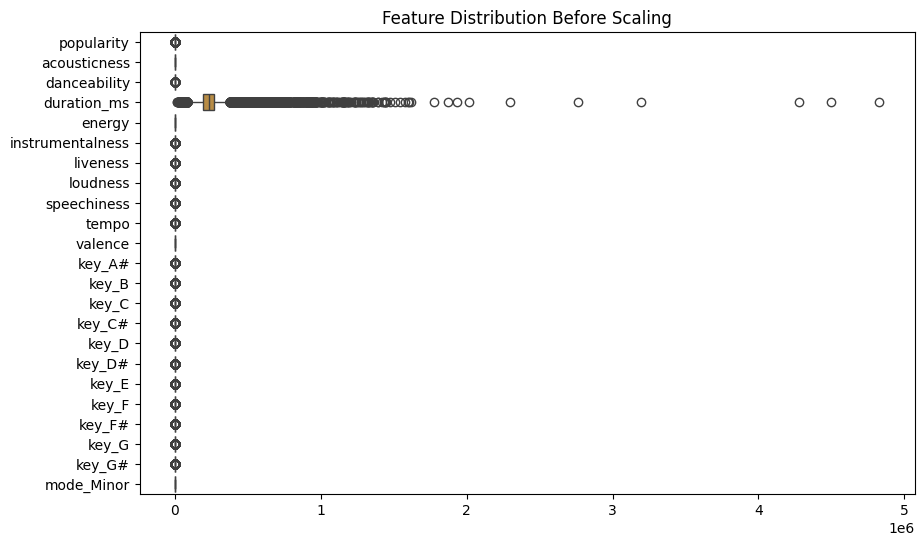

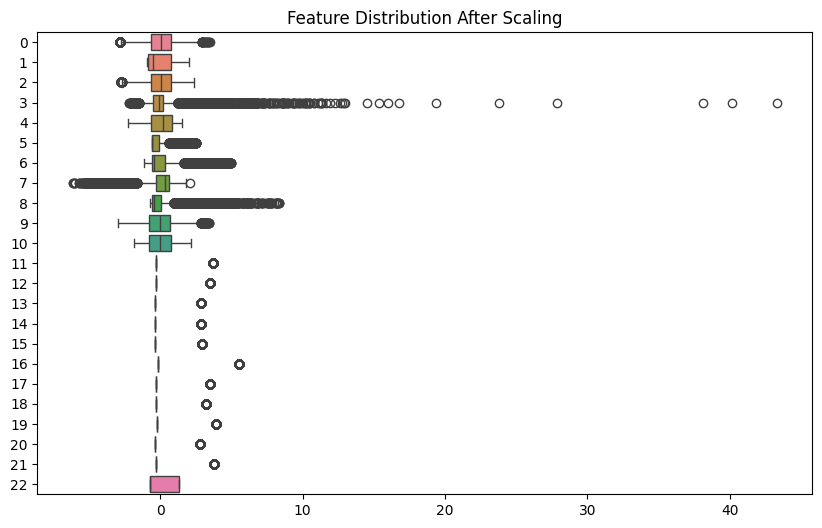

In [32]:
#Assumption Checks

# XGBoost Assumption Checks
print("\nXGBoost Assumption Checks")

# Check feature scaling (although XGBoost is less sensitive)
plt.figure(figsize=(10, 6))
sns.boxplot(data=features, orient='h')
plt.title('Feature Distribution Before Scaling')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=features_scaled, orient='h')
plt.title('Feature Distribution After Scaling')
plt.show()





XGBoost Feature Importance:


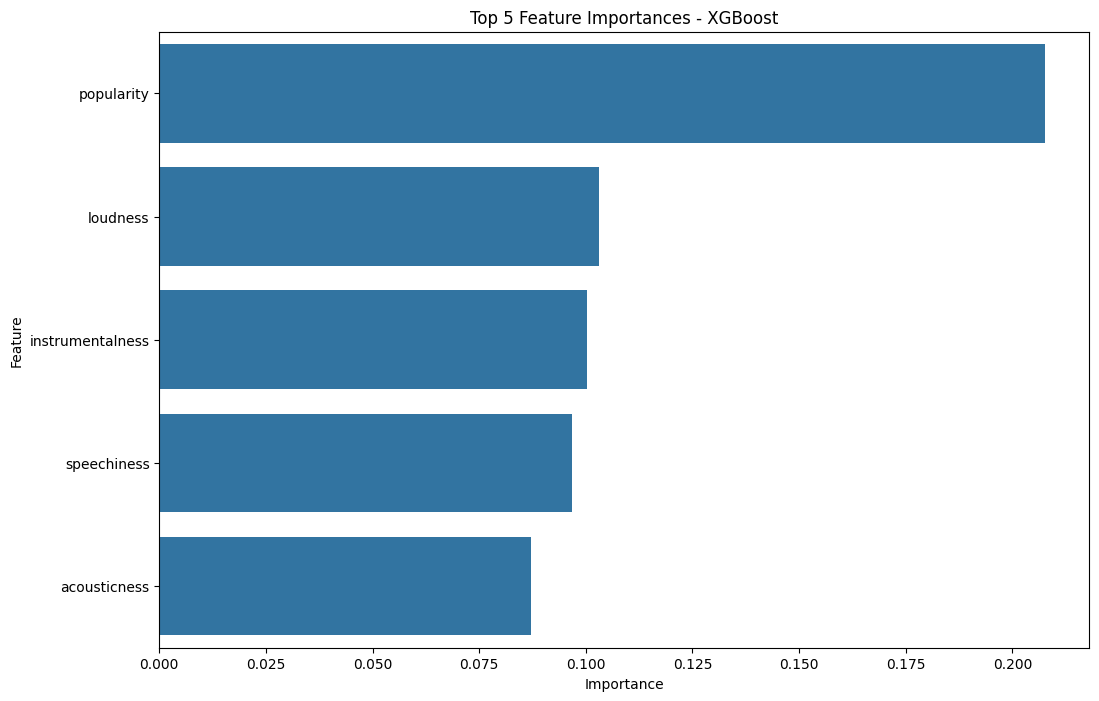

In [33]:
# Feature Importance for XGBoost

original_feature_names = features.columns

# Function to plot Feature Importances
def plot_feature_importances(importances, feature_names, model_name, top_n=5):
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False).head(top_n)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
    plt.title(f'Top {top_n} Feature Importances - {model_name}')
    plt.show()

# Plot XGBoost feature importances with the top 5 features
print("\nXGBoost Feature Importance:")
importances = best_xgb.feature_importances_
plot_feature_importances(importances, original_feature_names, "XGBoost", top_n=5)

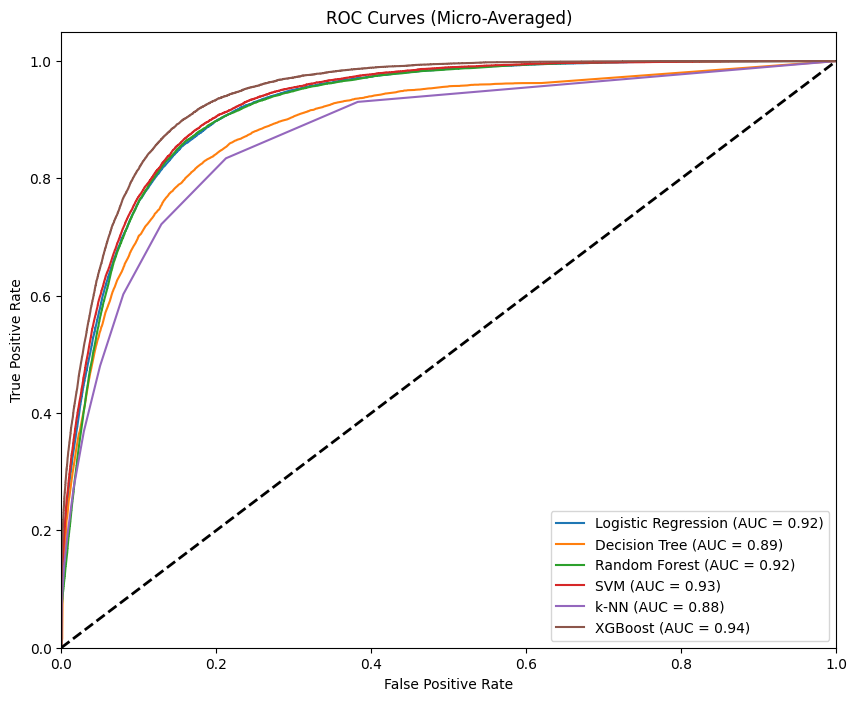

In [34]:
#ROC Curves

# Binarize the output for ROC curve
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_binarized.shape[1]

# Models
models = {
    "Logistic Regression": logistic_model,
    "Decision Tree": best_decision_tree,
    "Random Forest": bagging_rf_model,
    "SVM": best_svm,
    "k-NN": grid_search_knn.best_estimator_,
    "XGBoost": best_xgb
}

# Function to plot ROC Curves
def plot_roc_curves(models, X_test, X_test_poly, y_test_binarized):
    plt.figure(figsize=(10, 8))

    for name, model in models.items():
        if name == "Logistic Regression":
            X_test_input = X_test_poly
        else:
            X_test_input = X_test

        # 
        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(X_test_input)
        else:
            y_prob = model.decision_function(X_test_input)
            y_prob = (y_prob - y_prob.min()) / (y_prob.max() - y_prob.min())  # Scale to [0, 1]

        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_prob[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        
        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_prob.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
        
        plt.plot(fpr["micro"], tpr["micro"], label=f'{name} (AUC = {roc_auc["micro"]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves (Micro-Averaged)')
    plt.legend(loc='lower right')
    plt.show()

# Plot ROC Curves
plot_roc_curves(models, X_test, X_test_poly, y_test_binarized)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


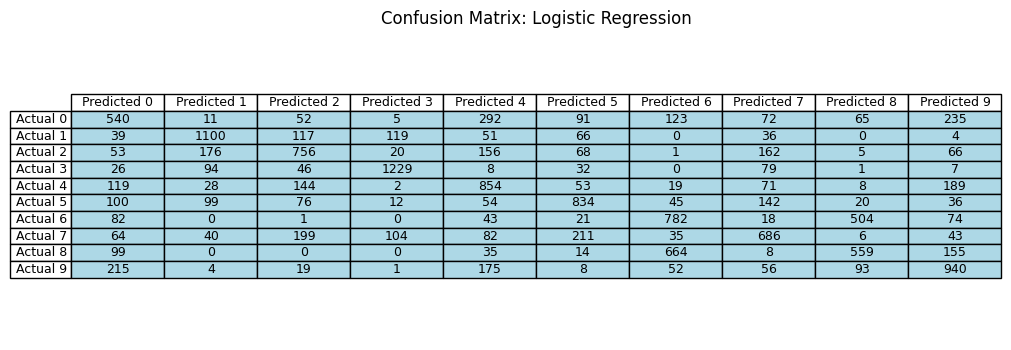

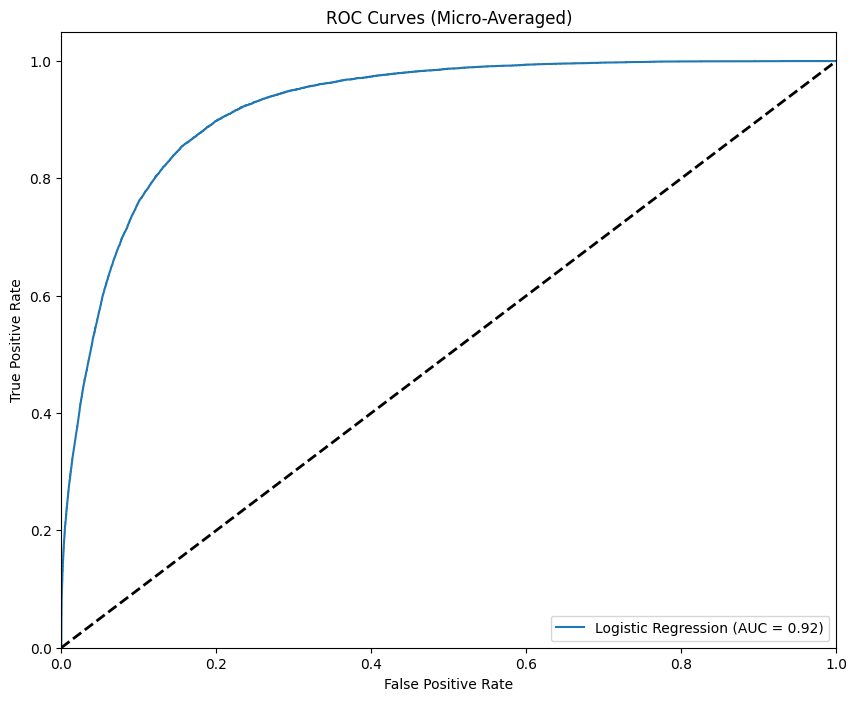

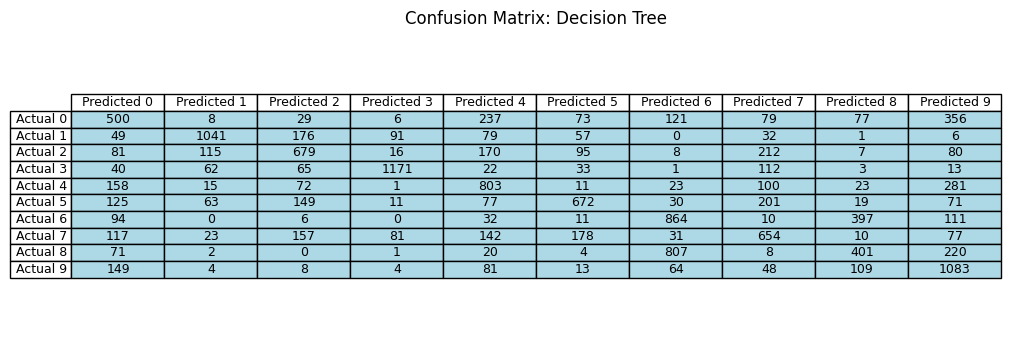

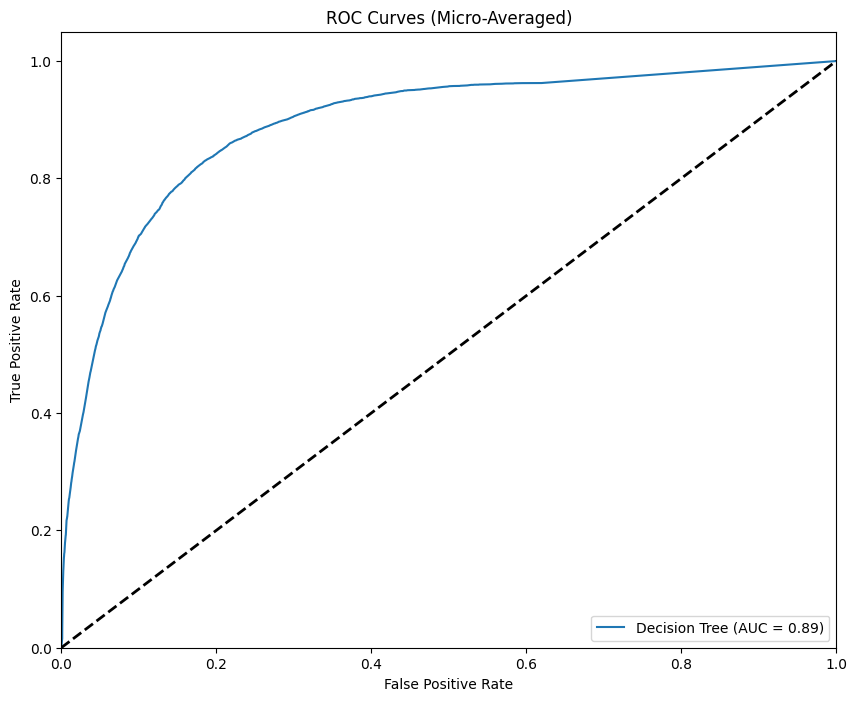

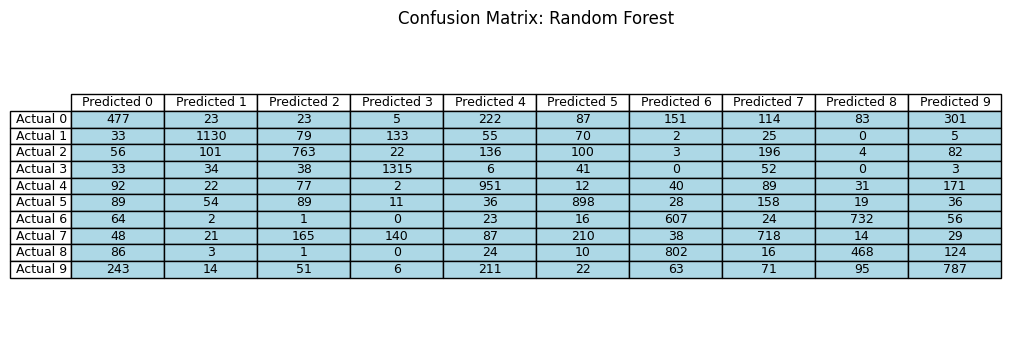

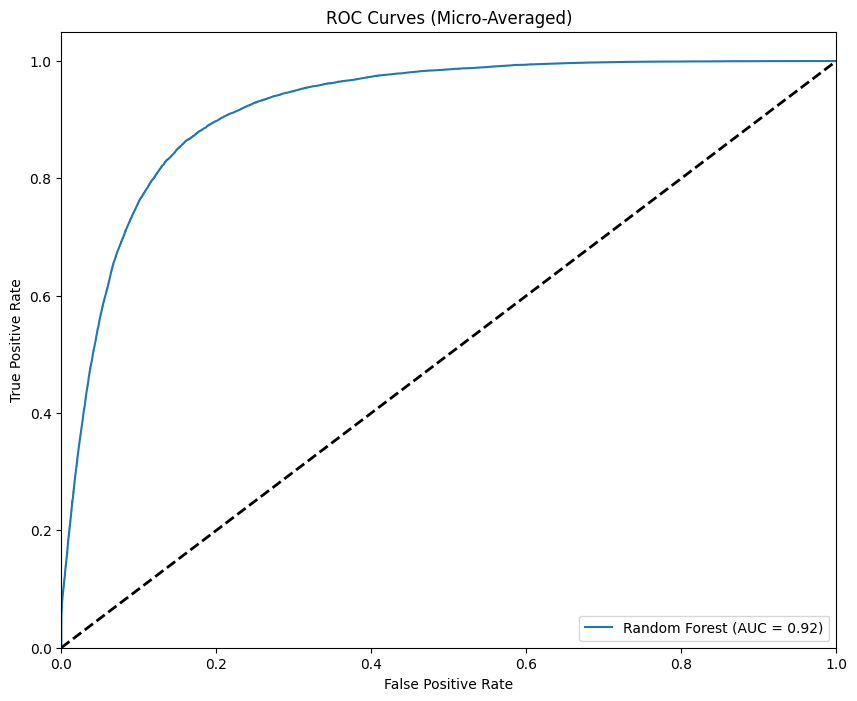

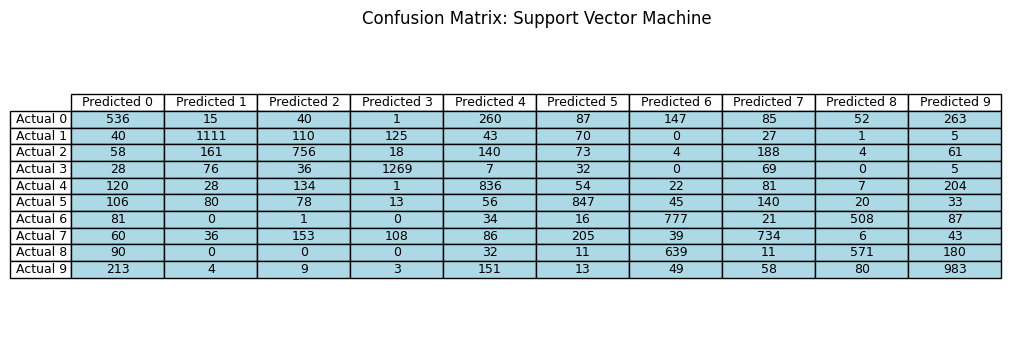

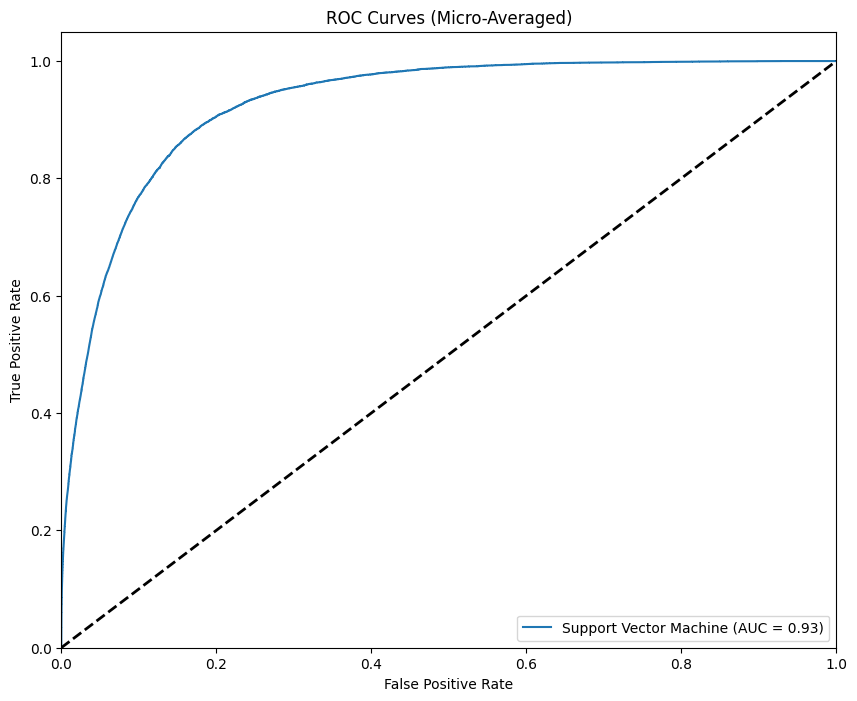

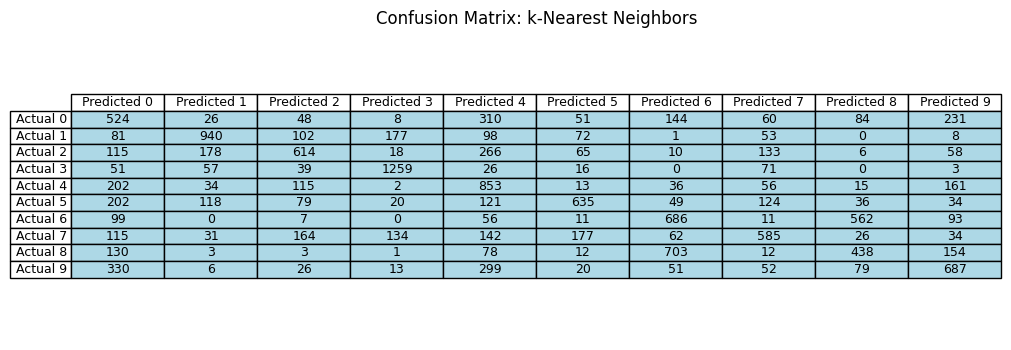

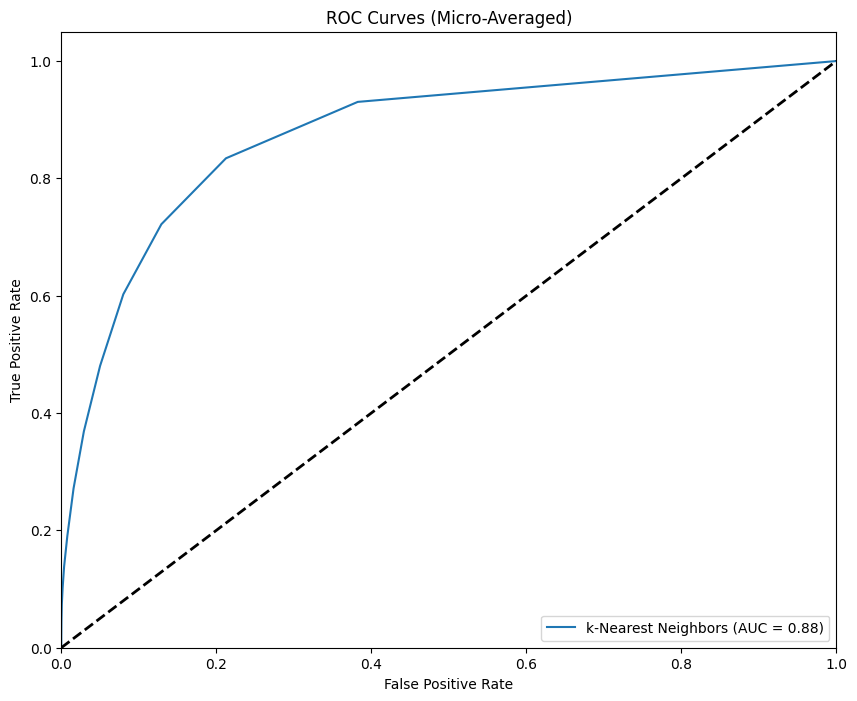

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:36:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


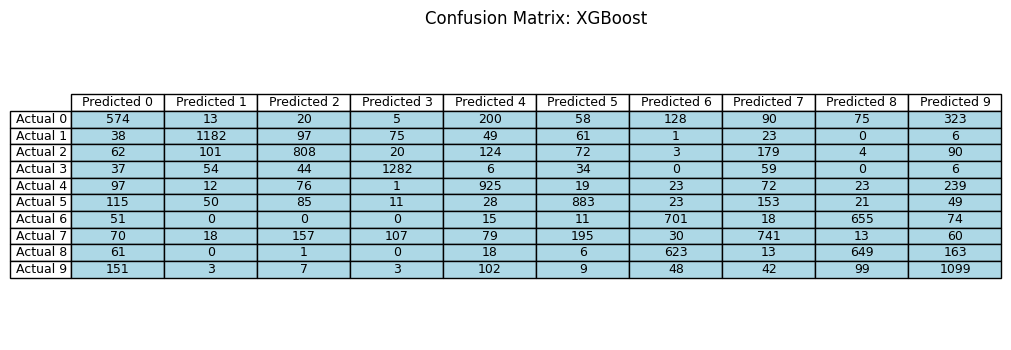

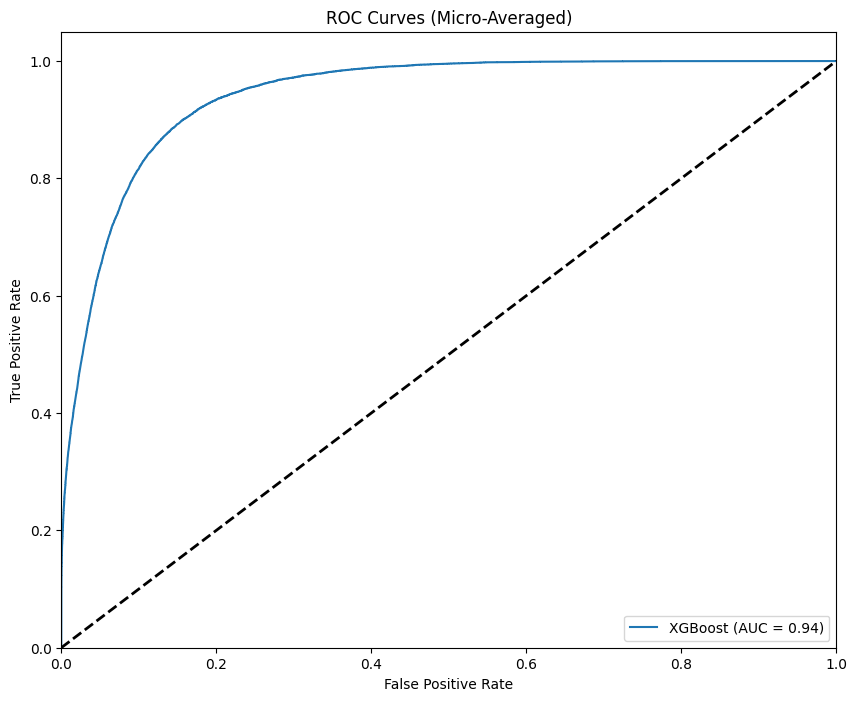

469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


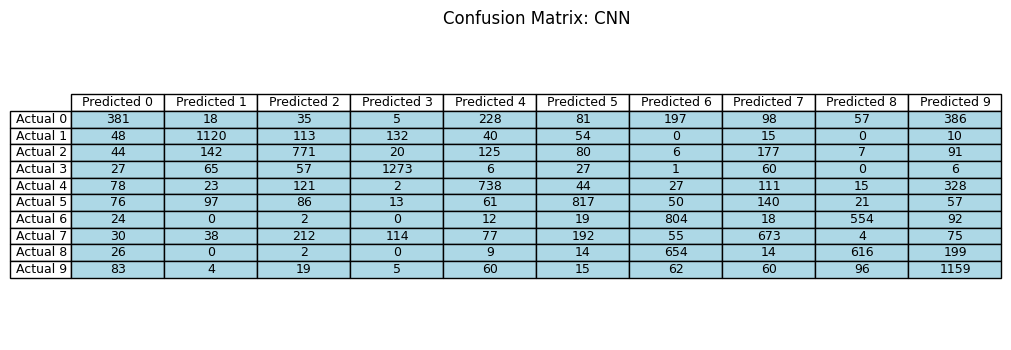

469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


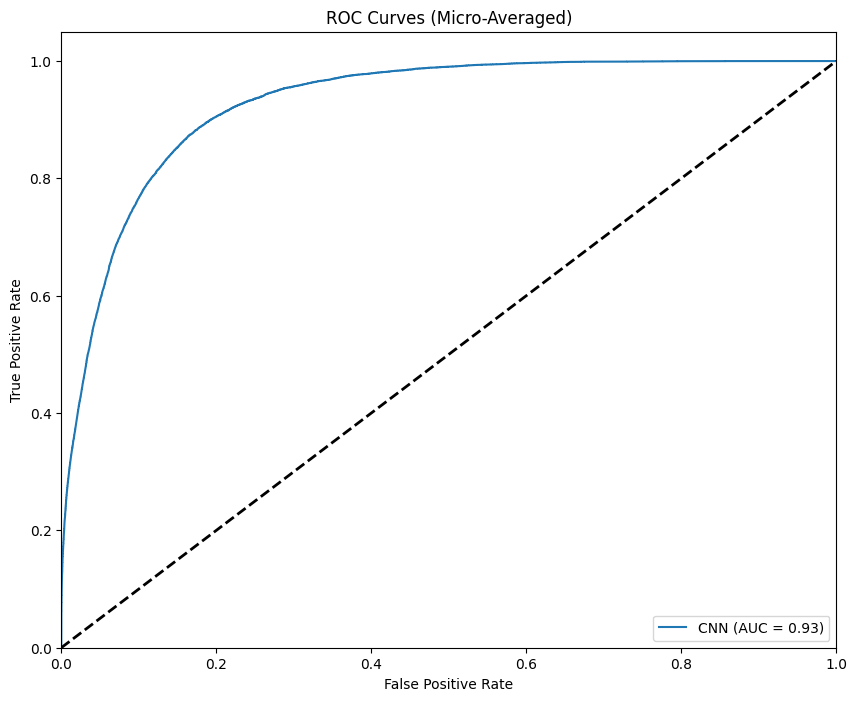

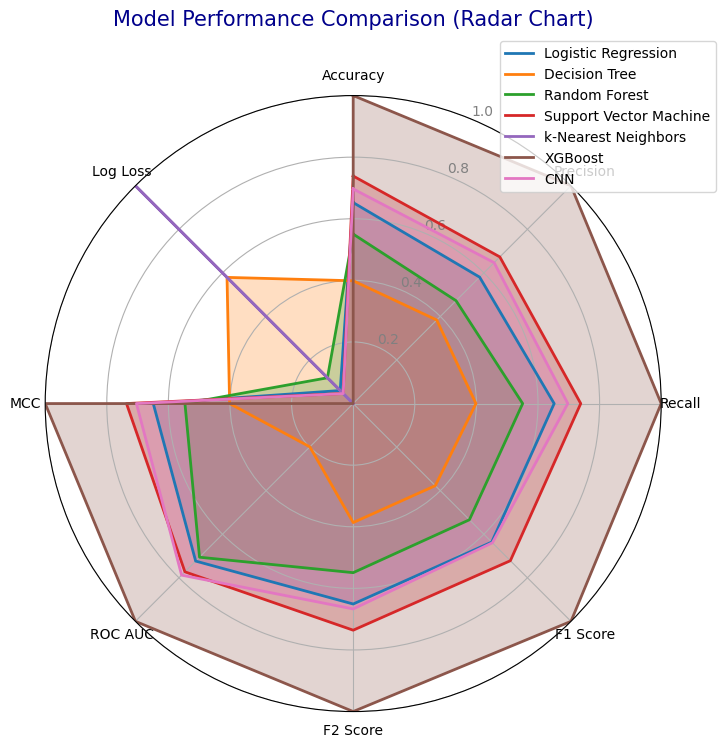

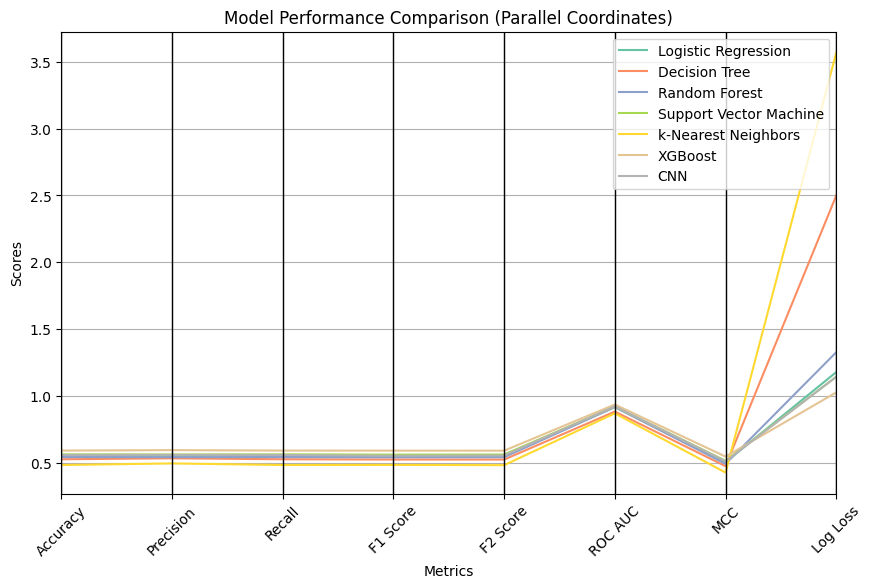

Metrics for all models:
                    Model  Accuracy  Precision    Recall  F1 Score  F2 Score  \
0     Logistic Regression  0.552000   0.551128  0.552000  0.550198  0.550950   
1           Decision Tree  0.524533   0.531527  0.524533  0.522492  0.522277   
2           Random Forest  0.540933   0.540361  0.540933  0.539235  0.539916   
3  Support Vector Machine  0.561333   0.560365  0.561333  0.559340  0.560172   
4     k-Nearest Neighbors  0.481400   0.493364  0.481400  0.482173  0.480367   
5                 XGBoost  0.589600   0.592874  0.589600  0.589110  0.588821   
6                     CNN  0.556800   0.557748  0.556800  0.550539  0.552687   

    ROC AUC       MCC  Log Loss  
0  0.916000  0.502474  1.177287  
1  0.881391  0.472852  2.499166  
2  0.914827  0.490178  1.326127  
3  0.919258  0.512860  1.142728  
4  0.868259  0.424906  3.569507  
5  0.934262  0.544400  1.025216  
6  0.920261  0.508999  1.141829  
The best model based on ROC AUC is: XGBoost with a ROC AUC of 0

In [35]:
# Model Comparison and Evaluation

# Function to plot confusion matrix as a simple number matrix
def plot_confusion_matrix_simple(cm, labels, model_name):
    plt.figure(figsize=(6, 4))
    plt.title(f'Confusion Matrix: {model_name}')
    
    plt.table(cellText=cm,
              cellLoc='center',
              colLabels=['Predicted ' + str(label) for label in labels],
              rowLabels=['Actual ' + str(label) for label in labels],
              loc='center',
              cellColours=[['lightblue'] * cm.shape[1]] * cm.shape[0],
              colWidths=[0.2] * cm.shape[1])
    
    plt.axis('off')  # Turn off the axis
    plt.show()

# Function to plot ROC Curves (adjusted for CNN)
def plot_roc_curves(models, X_test, X_test_poly, y_test_binarized):
    plt.figure(figsize=(10, 8))
    n_classes = y_test_binarized.shape[1]

    for name, model in models.items():
        if name == "Logistic Regression":
            X_test_input = X_test_poly
        else:
            X_test_input = X_test

        if isinstance(model, tf.keras.Model):
            y_prob = model.predict(X_test_input)
        elif hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(X_test_input)
        else:
            y_prob = model.decision_function(X_test_input)
            y_prob = (y_prob - y_prob.min()) / (y_prob.max() - y_prob.min())

        fpr, tpr, roc_auc = dict(), dict(), dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_prob[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_prob.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        plt.plot(fpr["micro"], tpr["micro"], label=f'{name} (AUC = {roc_auc["micro"]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves (Micro-Averaged)')
    plt.legend(loc='lower right')
    plt.show()

# Function to ensure consistent metric calculation for each model
def evaluate_model_extended(model, X_train, X_test, X_train_poly, X_test_poly, y_train, y_test, model_name):
    if model_name == "Logistic Regression":
        model.fit(X_train_poly, y_train)
        X_test_input = X_test_poly
    else:
        model.fit(X_train, y_train)
        X_test_input = X_test

    if hasattr(model, 'predict_proba'):
        y_prob = model.predict_proba(X_test_input)
        y_pred = np.argmax(y_prob, axis=1)
    else:
        y_prob = model.predict(X_test_input)
        if len(y_prob.shape) > 1:
            y_pred = np.argmax(y_prob, axis=1)
        else:
            y_pred = y_prob

    y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))

    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    f2 = fbeta_score(y_test, y_pred, beta=2, average='weighted')
    mcc = matthews_corrcoef(y_test, y_pred)
    logloss = log_loss(y_test, y_prob)
    conf_matrix = confusion_matrix(y_test, y_pred)

    plot_confusion_matrix_simple(conf_matrix, np.unique(y_test), model_name)

    roc_auc = roc_auc_score(y_test_binarized, y_prob, multi_class='ovr')

    plot_roc_curves({model_name: model}, X_test, X_test_poly, y_test_binarized)

    metrics_data = {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'F2 Score': f2,
        'ROC AUC': roc_auc,
        'MCC': mcc,
        'Log Loss': logloss
    }
    return metrics_data

# CNN evaluation function
def evaluate_cnn_model(cnn_model, X_test_cnn, y_test, model_name):
    cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test_cnn, y_test, verbose=0)
    y_pred_cnn = cnn_model.predict(X_test_cnn)

    y_pred_labels = np.argmax(y_pred_cnn, axis=1)
    logloss = log_loss(y_test, y_pred_cnn)

    accuracy = accuracy_score(y_test, y_pred_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_labels, average='weighted')
    f2 = fbeta_score(y_test, y_pred_labels, beta=2, average='weighted')
    mcc = matthews_corrcoef(y_test, y_pred_labels)
    conf_matrix = confusion_matrix(y_test, y_pred_labels)

    plot_confusion_matrix_simple(conf_matrix, np.unique(y_test), model_name)

    y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
    roc_auc = roc_auc_score(y_test_binarized, y_pred_cnn, multi_class='ovr')

    plot_roc_curves({model_name: cnn_model}, X_test_cnn, X_test_cnn, y_test_binarized)

    metrics_data = {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'F2 Score': f2,
        'ROC AUC': roc_auc,
        'MCC': mcc,
        'Log Loss': logloss
    }
    return metrics_data

# Function to plot radar chart for model comparison
def plot_radar_chart(models_score_df):
    labels = models_score_df.columns[1:]
    num_vars = len(labels)

    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    for i, row in models_score_df.iterrows():
        values = row.drop('Model').tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=row['Model'])
        ax.fill(angles, values, alpha=0.25)

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    plt.xticks(angles[:-1], labels)
    plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], color="grey", size=10)
    plt.ylim(0, 1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
    plt.title('Model Performance Comparison (Radar Chart)', size=15, color='darkblue', y=1.1)
    plt.show()

# Function to plot parallel coordinates for model comparison
def plot_parallel_coordinates(models_score_df):
    plt.figure(figsize=(10, 6))
    parallel_coordinates(models_score_df, class_column='Model', colormap=plt.get_cmap("Set2"))
    plt.title('Model Performance Comparison (Parallel Coordinates)')
    plt.xlabel('Metrics')
    plt.ylabel('Scores')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()

# Model evaluation and plotting
best_models = {
    "Logistic Regression": logistic_model,
    "Decision Tree": best_decision_tree,
    "Random Forest": bagging_rf_model,
    "Support Vector Machine": best_svm,
    "k-Nearest Neighbors": grid_search_knn.best_estimator_,
    "XGBoost": best_xgb,
    "CNN": None  # Handle CNN separately
}

models_score_table = []

# Evaluate non-CNN models
for model_name, model in best_models.items():
    if model_name != "CNN":
        metrics = evaluate_model_extended(model, X_train, X_test, X_train_poly, X_test_poly, y_train, y_test, model_name)
        models_score_table.append(metrics)

# Evaluate CNN separately
cnn_metrics = evaluate_cnn_model(cnn_model, X_test_cnn, y_test, "CNN")
models_score_table.append(cnn_metrics)

# Convert metrics to DataFrame
models_score_df = pd.DataFrame(models_score_table)

# Normalize the scores to the [0, 1] range for radar chart
normalized_df = models_score_df.copy()
normalized_df.iloc[:, 1:] = (normalized_df.iloc[:, 1:] - models_score_df.iloc[:, 1:].min()) / (models_score_df.iloc[:, 1:].max() - models_score_df.iloc[:, 1:].min())

# Plot radar chart and parallel coordinates to compare models
plot_radar_chart(normalized_df)
plot_parallel_coordinates(models_score_df)

# Print out the models score table for reference
print("Metrics for all models:")
print(models_score_df)

# Identify the best model based on ROC AUC
best_model_roc_auc = models_score_df.loc[models_score_df['ROC AUC'].idxmax()]
print(f"The best model based on ROC AUC is: {best_model_roc_auc['Model']} with a ROC AUC of {best_model_roc_auc['ROC AUC']:.2f}")

# Identify the best model based on other metrics, like Accuracy:
best_model_accuracy = models_score_df.loc[models_score_df['Accuracy'].idxmax()]
print(f"The best model based on Accuracy is: {best_model_accuracy['Model']} with an Accuracy of {best_model_accuracy['Accuracy']:.2f}")

# Identify the best model based on Precision, Recall, F1 Score, etc.
best_model_precision = models_score_df.loc[models_score_df['Precision'].idxmax()]
print(f"The best model based on Precision is: {best_model_precision['Model']} with a Precision of {best_model_precision['Precision']:.2f}")

best_model_recall = models_score_df.loc[models_score_df['Recall'].idxmax()]
print(f"The best model based on Recall is: {best_model_recall['Model']} with a Recall of {best_model_recall['Recall']:.2f}")

best_model_f1 = models_score_df.loc[models_score_df['F1 Score'].idxmax()]
print(f"The best model based on F1 Score is: {best_model_f1['Model']} with an F1 Score of {best_model_f1['F1 Score']:.2f}")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Shape of X_test_top_5_df: (15000, 5)
Shape of shap_values_top_5: (15000, 5)


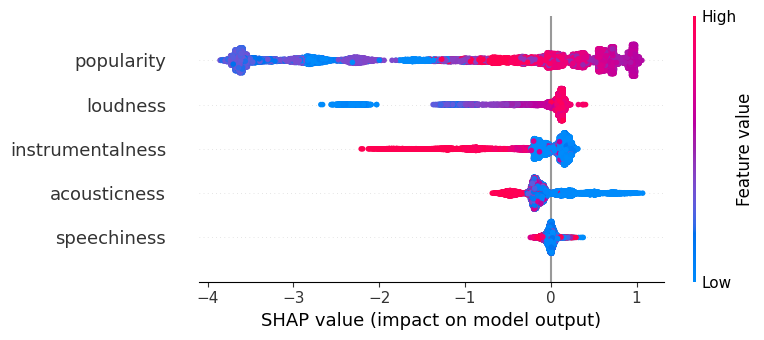

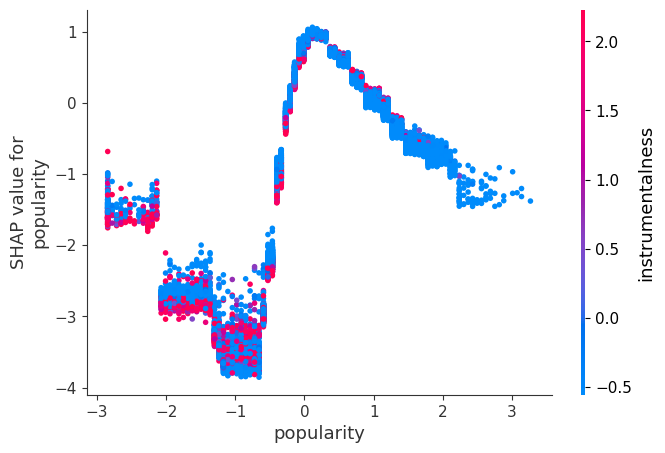

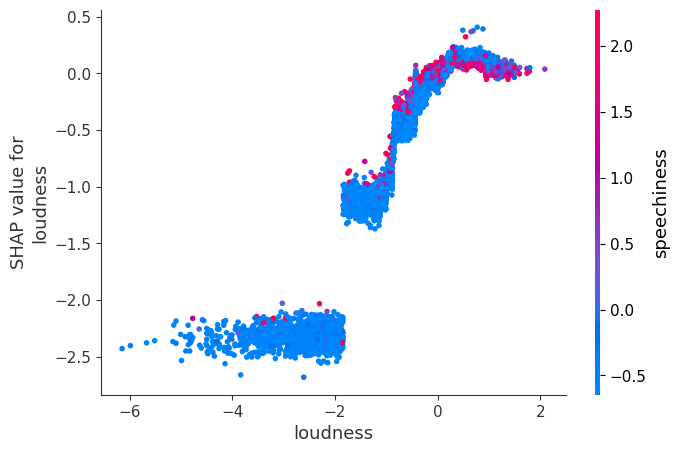

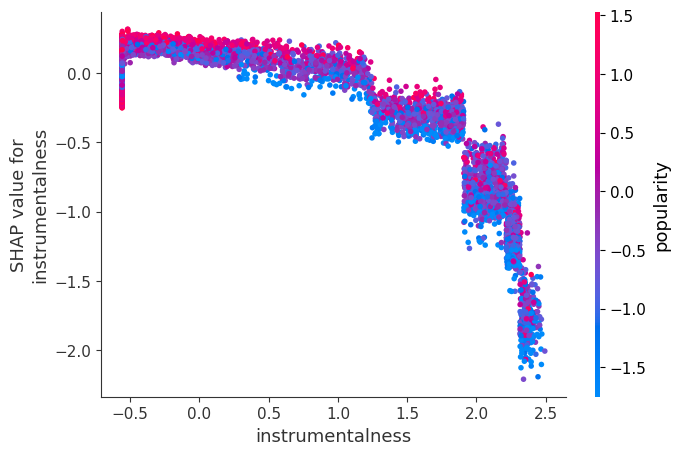

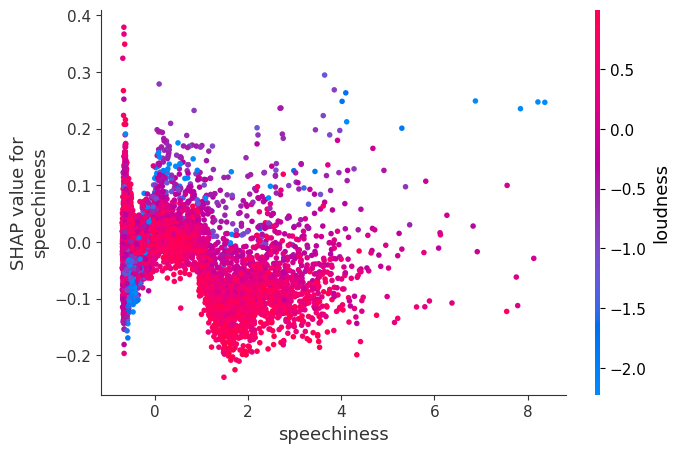

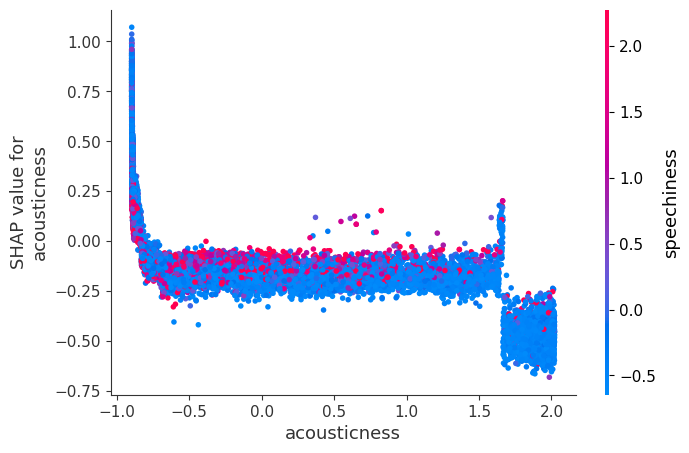

In [36]:
#SHAP Top 5 Features

# Define full feature names
all_feature_names = [
    "popularity", "acousticness", "danceability", "duration_ms", "energy", "instrumentalness", 
    "liveness", "loudness", "speechiness", "tempo", "valence", "key_A#", "key_B", "key_C", 
    "key_C#", "key_D", "key_D#", "key_E", "key_F", "key_F#", "key_G", "key_G#", "mode_Minor"
]

# Define top 5 features
top_5_features = [
    'popularity', 'loudness', 'instrumentalness', 'speechiness', 'acousticness'
]

# Create SHAP explainer
explainer = shap.Explainer(best_xgb)

# Calculate SHAP values for the entire test set
shap_values = explainer(X_test)

# Extract raw SHAP values
shap_values_array = shap_values.values  # Shape (num_samples, num_features, num_outputs)

# Select SHAP values for a specific class (e.g., class index 0 for simplicity)
class_index = 0
shap_values_class = shap_values_array[:, :, class_index]  # Shape (num_samples, num_features)

# Extract indices of the top 5 features
top_5_feature_indices = [all_feature_names.index(f) for f in top_5_features]

# Get SHAP values for the top 5 features
shap_values_top_5 = shap_values_class[:, top_5_feature_indices]  # Shape (num_samples, len(top_5_features))

# Create DataFrame for SHAP values
shap_values_df_top_5 = pd.DataFrame(shap_values_top_5, columns=top_5_features)

# Create DataFrame for X_test with top 5 features only
X_test_top_5_df = pd.DataFrame(X_test[:, top_5_feature_indices], columns=top_5_features)

# Check dimensions
print("Shape of X_test_top_5_df:", X_test_top_5_df.shape)
print("Shape of shap_values_top_5:", shap_values_top_5.shape)

# Summary plot for top 5 features
try:
    shap.summary_plot(shap_values_top_5, X_test_top_5_df, feature_names=top_5_features)
except Exception as e:
    print("Error creating summary plot for top 5 features:", e)

# Generate dependence plots for each top 5 feature
for feature_name in top_5_features:
    try:
        feature_index = top_5_features.index(feature_name)
        shap.dependence_plot(
            ind=feature_index,  # Index of the feature in top_5_features
            shap_values=shap_values_top_5,  # SHAP values for the top 5 features
            features=X_test[:, top_5_feature_indices],  # Use only the top 5 features
            feature_names=top_5_features
        )
    except Exception as e:
        print(f"Error creating dependence plot for {feature_name}:", e)

In [37]:
#Music Recommender

# Load the original dataset with track names and genres
original_data = pd.read_csv("music_genre_cleaned.csv")[['track_name', 'music_genre']]

# Encode 'music_genre' the same way as done in the training
original_data['genre_encoded'] = label_encoder.transform(original_data['music_genre'])

# Split original data into train and test sets to align with X_train and X_test
original_train, original_test = train_test_split(original_data, test_size=0.3, random_state=40399224)

# Load best model
best_xgb = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
best_xgb.fit(X_train, y_train) 

# Function to recommend similar tracks based on track name
def recommend_similar_tracks_by_name(track_name, top_n=5):
    """
    Given a track name, recommend top_n similar tracks based on genre and feature similarity.
    """
    # Find the index of the track in the original dataset
    track_index = original_data[original_data['track_name'] == track_name].index

    if len(track_index) == 0:
        return f"Track '{track_name}' not found in the dataset.", None, None

    track_index = track_index[0]  # Get the first match

    # Get the features of the input track
    input_track_features = X_test[track_index].reshape(1, -1)

    # Predict the genre of the input track using the best model
    predicted_genre_encoded = best_xgb.predict(input_track_features)[0]

    # Filter the original test data to only include tracks of the predicted genre
    genre_mask = (original_test['genre_encoded'] == predicted_genre_encoded)

    # Filter corresponding feature vectors and track names for the predicted genre
    genre_features = X_test[genre_mask]
    genre_track_names = original_test[genre_mask]['track_name'].reset_index(drop=True)
    genre_music_genres = original_test[genre_mask]['music_genre'].reset_index(drop=True)

    # Compute cosine similarity between the input track and all tracks of the predicted genre
    similarities = cosine_similarity(input_track_features, genre_features).flatten()

    # Get the indices of the most similar tracks (excluding the input track itself)
    similar_indices = np.argsort(similarities)[::-1]  # Sort in descending order
    similar_indices = similar_indices[similar_indices != track_index]  # Exclude input track
    
    # Ensure there are enough similar tracks to recommend
    if len(similar_indices) == 0:
        return "No similar tracks found.", None, None

    # Get the top_n similar tracks
    top_similar_indices = similar_indices[:top_n]
    
    # Get the recommended tracks and their genres
    recommended_tracks = genre_track_names.iloc[top_similar_indices].values
    recommended_genres = genre_music_genres.iloc[top_similar_indices].values

    # Get the predicted genre name for the input track
    predicted_genre_name = label_encoder.inverse_transform([predicted_genre_encoded])[0]

    return recommended_tracks, recommended_genres, predicted_genre_name

# Example usage:
track_name = "Lazer Beam"  # Example track name
result = recommend_similar_tracks_by_name(track_name, top_n=5)

# Print the results
if isinstance(result, tuple) and len(result) == 3:
    recommended_tracks, recommended_genres, predicted_genre = result

    if recommended_tracks is not None:
        print(f"Track Name: {track_name}")
        print(f"Predicted Genre for '{track_name}': {predicted_genre}")
        print("Recommended Tracks and their Genres:")
        for i in range(len(recommended_tracks)):
            print(f"{recommended_tracks[i]} (Genre: {recommended_genres[i]})")
    else:
        print(result[0])  # Print error message if no recommendations found
else:
    print(result)  # Print error message if track not found

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:37:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Track Name: Lazer Beam
Predicted Genre for 'Lazer Beam': Rock
Recommended Tracks and their Genres:
In This Love (Genre: Rock)
Left Hand Free (Genre: Rock)
Woman (Genre: Rock)
Let Your Love Flow (Genre: Rock)
Waiting For You (Genre: Rock)


In [38]:
# Get the original genre names from the LabelEncoder
genre_names = label_encoder.classes_

# Print out the mapping of encoded labels to original genre names
for i, genre in enumerate(genre_names):
    print(f"Encoded label {i}: {genre}")

Encoded label 0: Alternative
Encoded label 1: Anime
Encoded label 2: Blues
Encoded label 3: Classical
Encoded label 4: Country
Encoded label 5: Electronic
Encoded label 6: Hip-Hop
Encoded label 7: Jazz
Encoded label 8: Rap
Encoded label 9: Rock
